In [1]:
# import necessary libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def extract_content(images):
    extracted_images = []
    for image in images:
        # Calculate black pixels in rows and columns
        black_pixels_in_rows = [np.sum(image[i, :] == 0) for i in range(image.shape[0])]
        black_pixels_in_columns = [np.sum(image[:, j] == 0) for j in range(image.shape[1])]

        # Defining a threshold for considering an area as content
        row_threshold = max(black_pixels_in_rows)// 8
        col_threshold = max(black_pixels_in_columns)// 8

        # Finding the rows and columns that contain the content
        rows_with_content = [i for i, count in enumerate(black_pixels_in_rows) if count > row_threshold]
        cols_with_content = [j for j, count in enumerate(black_pixels_in_columns) if count > col_threshold]

        # Extracting the content from the image
        #extracted_image = image[rows_with_content[0]:rows_with_content[-1]+1, cols_with_content[0]:cols_with_content[-1]+1]
        extracted_image = image[rows_with_content[0]:rows_with_content[-1]+1, :]

        # Appending the extracted image to the list
        extracted_images.append(extracted_image)

        # Plotting the histograms and the extracted content
        plt.figure(figsize=(15, 5))

        # Plotting histogram for black pixels in rows
        plt.subplot(1, 4, 1)
        plt.barh(range(len(black_pixels_in_rows)), black_pixels_in_rows)
        plt.title("Black Pixels in Rows")
        plt.xlabel("Number of Black Pixels")
        plt.ylabel("Number of Rows")

        # Plotting histogram for black pixels in columns
        plt.subplot(1, 4, 2)
        plt.bar(range(len(black_pixels_in_columns)), black_pixels_in_columns)
        plt.title("Black Pixels in Columns")
        plt.ylabel("Number of Black Pixels")
        plt.xlabel("Number of Columns")

        # Plotting the original image
        plt.subplot(1, 4, 3)
        plt.imshow(image, cmap='gray')
        plt.title("Original Image")

        # Plotting the extracted content
        plt.subplot(1, 4, 4)
        plt.imshow(extracted_image, cmap='gray')
        plt.title("Extracted Content")

        plt.tight_layout()
        plt.show()
    
    return extracted_images

In [3]:
# for initial noise removal
# here noise can be the underlines
# gray_scale -> median_filter -> mean_filter -> binary_image

def initial_filter(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filtered_image = cv2.medianBlur(gray_image, 3)
    filtered_image = cv2.filter2D(filtered_image, -1, np.ones((5, 5), dtype=np.float32) / (5**2))
    binary_image = (filtered_image>=127).astype(int)
    return binary_image

In [4]:
# column-wise sum to know pixel values present in each column
# Example:

# [0 1 1]
# [0 0 1]
# [1 1 1]

# col1 = 0 + 0 + 1 = 1
# col2 = 1 + 0 + 1 = 2
# col3 = 1 + 1 + 1 = 3

def calculate_col_sums(segmented):
    neg = 1 - segmented
    column_sums = np.sum(neg, axis=0)
    plt.figure(figsize=(20, 15))
    plt.bar(range(len(column_sums)), column_sums)
    plt.xlabel("Columns")
    plt.ylabel("Sum of Rows")
    plt.show()
    
    return column_sums

In [36]:
# calculating coordinates of characters
# start of information pixels
# end of information pixels

def calculate_coords(column_sums):
    start_coords = []
    end_coords = []

    local_sum = 0

    in_transition = False
    for i in range(len(column_sums) - 1):
        if (column_sums[i] == 0) and column_sums[i + 1] > 0 and not in_transition:

            start_coords.append(i)
            in_transition = True

        elif ((column_sums[i] > 0 and column_sums[i + 1] == 0)) and in_transition:

            if i-start_coords[-1]<5:
                start_coords.pop()
            else:
                end_coords.append(i)

            in_transition = False

        local_sum += column_sums[i]
    
    if column_sums[i] != 0 and len(end_coords)!=len(start_coords):
        end_coords.append(i)
    return [start_coords, end_coords]

In [6]:
def filtering(start_coords, end_coords, segmented):
    images = []
    kernel_size = (3,3)

    plt.figure(figsize=(20, 20))
    for i in range(len(start_coords)):
        img = segmented[:, start_coords[i]: end_coords[i]+1]
        img = cv2.convertScaleAbs(img)

        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
        img = cv2.filter2D(img, -1, kernel)
        img = cv2.medianBlur(img, 3)
        images.append(img)

    for i in range(len(images)):
        filtered_image = images[i]
        kernel = np.ones((3, 3), np.uint8)
        for j in range(1, 3 + 1, 2):
            filtered_image  = cv2.medianBlur(filtered_image , j)
        images[i] = cv2.erode(filtered_image, kernel, iterations=1) 

    i = 1
    for x in images:
        plt.subplot(6, 6, i)
        plt.imshow(x, cmap='gray')
        i += 1
    
    return images

In [7]:
# resizing all characters to same dimesion by padding

def resized(images):

    new_images = []

    for img in images:
        rows, cols = img.shape
        req_rows = rows - (rows % 28) + 28
        req_cols = cols - (cols % 28) + 28
        n = max(req_cols, req_rows)
        image = 1-img
        arr = np.zeros((n, n))

        rows_to_append = (n - rows) // 2
        cols_to_append = (n - cols) // 2

        result = np.zeros_like(arr)

        result[:rows_to_append, :] = 0
        result[-rows_to_append:, :] = 0

        result[:, :cols_to_append] = 0
        result[:, -cols_to_append:] = 0
        result[rows_to_append:rows_to_append + rows, cols_to_append:cols_to_append + cols] = image

        new_images.append(result)

    plt.figure(figsize=(20, 20))    

    i = 1
    for x in new_images:
        plt.subplot(6, 6, i)
        plt.imshow(x, cmap='gray')
        i += 1
    
    plt.figure(figsize=(20, 20))
    
    p_img = []
    i=0
    for x in new_images:
        reshaped_image = cv2.resize(x, (28, 28))
        reshaped_image = (reshaped_image>=0.5).astype(int)
        plt.subplot(6,6,i+1)
        i += 1
        p_img.append(reshaped_image)
        plt.imshow(reshaped_image, cmap='gray')
    
    return p_img

In [8]:
def predict_letters(p_img):
    extracted = ''
    i=1
    plt.figure(figsize=(20,20))
    for x in p_img:
        plt.subplot(6,6,i)
        plt.imshow(x, cmap='gray')
        x = x.T
        x = x.reshape(1, 28, 28, 1)
        m = model.predict(x)
        ypred = d[np.argmax(m)+1]

        plt.title(ypred)
        extracted += ypred
        i += 1
    
    return extracted

In [9]:
def predict_digit(resized_images):
    num = ''
    for x in resized_images:
        x = x.reshape(-1, 28, 28)
        num += str(np.argmax(digit_model.predict(x)))
    return int(num)

In [10]:
def find_spaces(start_coords, end_coords, extracted):

    total_space_widths = 0
    max_space = -1
    min_space = 1000
    for i in range(1, len(start_coords)):
        l = start_coords[i] - end_coords[i-1]
        total_space_widths += l
        max_space, min_space = max(max_space, l), min(min_space, l)

    breaking_space = (max_space - min_space)/ 2

    spaces = []
    for i in range(1, len(start_coords)):
        if start_coords[i] - end_coords[i-1] >= breaking_space:
            spaces.append(i)
    
    name = ''
    included = False
    i = 0
    while i<len(start_coords):
        if i in spaces and not included:
            name += ' '
            included = True
        else:
            name += extracted[i]
            included = False
            i += 1
    return name

In [12]:
df = pd.read_csv(r"/kaggle/input/digit-recognizer/train.csv")
y = df.iloc[:,0]
x = df.iloc[:,1:785]
Y = np.array(y)
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

X = x.values.reshape(-1, 28, 28)
X = (X>=127).astype(int)
X = X/255.
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.15, random_state=42)

digit_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

digit_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

digit_model.fit(xtrain, ytrain, epochs=10)
#digit_model.save('digit_model.h5')

2024-04-28 20:21:29.615948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 20:21:29.616162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 20:21:29.787409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3880 - loss: 1.6545
Epoch 2/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9086 - loss: 0.2906
Epoch 3/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9377 - loss: 0.1913
Epoch 4/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9537 - loss: 0.1453
Epoch 5/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9625 - loss: 0.1173
Epoch 6/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9676 - loss: 0.1056
Epoch 7/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9716 - loss: 0.0917
Epoch 8/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9721 - loss: 0.0852
Epoch 9/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9763 - loss: 0.0754
Epoch 10/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9773 - loss: 0.0708


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,610 (951.60 KB)

 Trainable params: 243,610 (951.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.4807 - loss: 1.7439 - val_accuracy: 0.8847 - val_loss: 0.3584
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.8434 - loss: 0.4822 - val_accuracy: 0.9028 - val_loss: 0.2926
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 52s 109ms/step - accuracy: 0.8765 - loss: 0.3794 - val_accuracy: 0.9184 - val_loss: 0.2450
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.8922 - loss: 0.3197 - val_accuracy: 0.9259 - val_loss: 0.2276
Epoch 5/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.9024 - loss: 0.3019 - val_accuracy: 0.9302 - val_loss: 0.2105
Epoch 6/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 52s 109ms/step - accuracy: 0.9072 - loss: 0.2782 - val_accuracy: 0.9319 - val_loss: 0.2074
Epoch 7/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.9118 - loss: 0.2599 - val_accuracy: 0.9303 - val_loss: 0.2110
Epoch 8/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.9155 - loss: 0

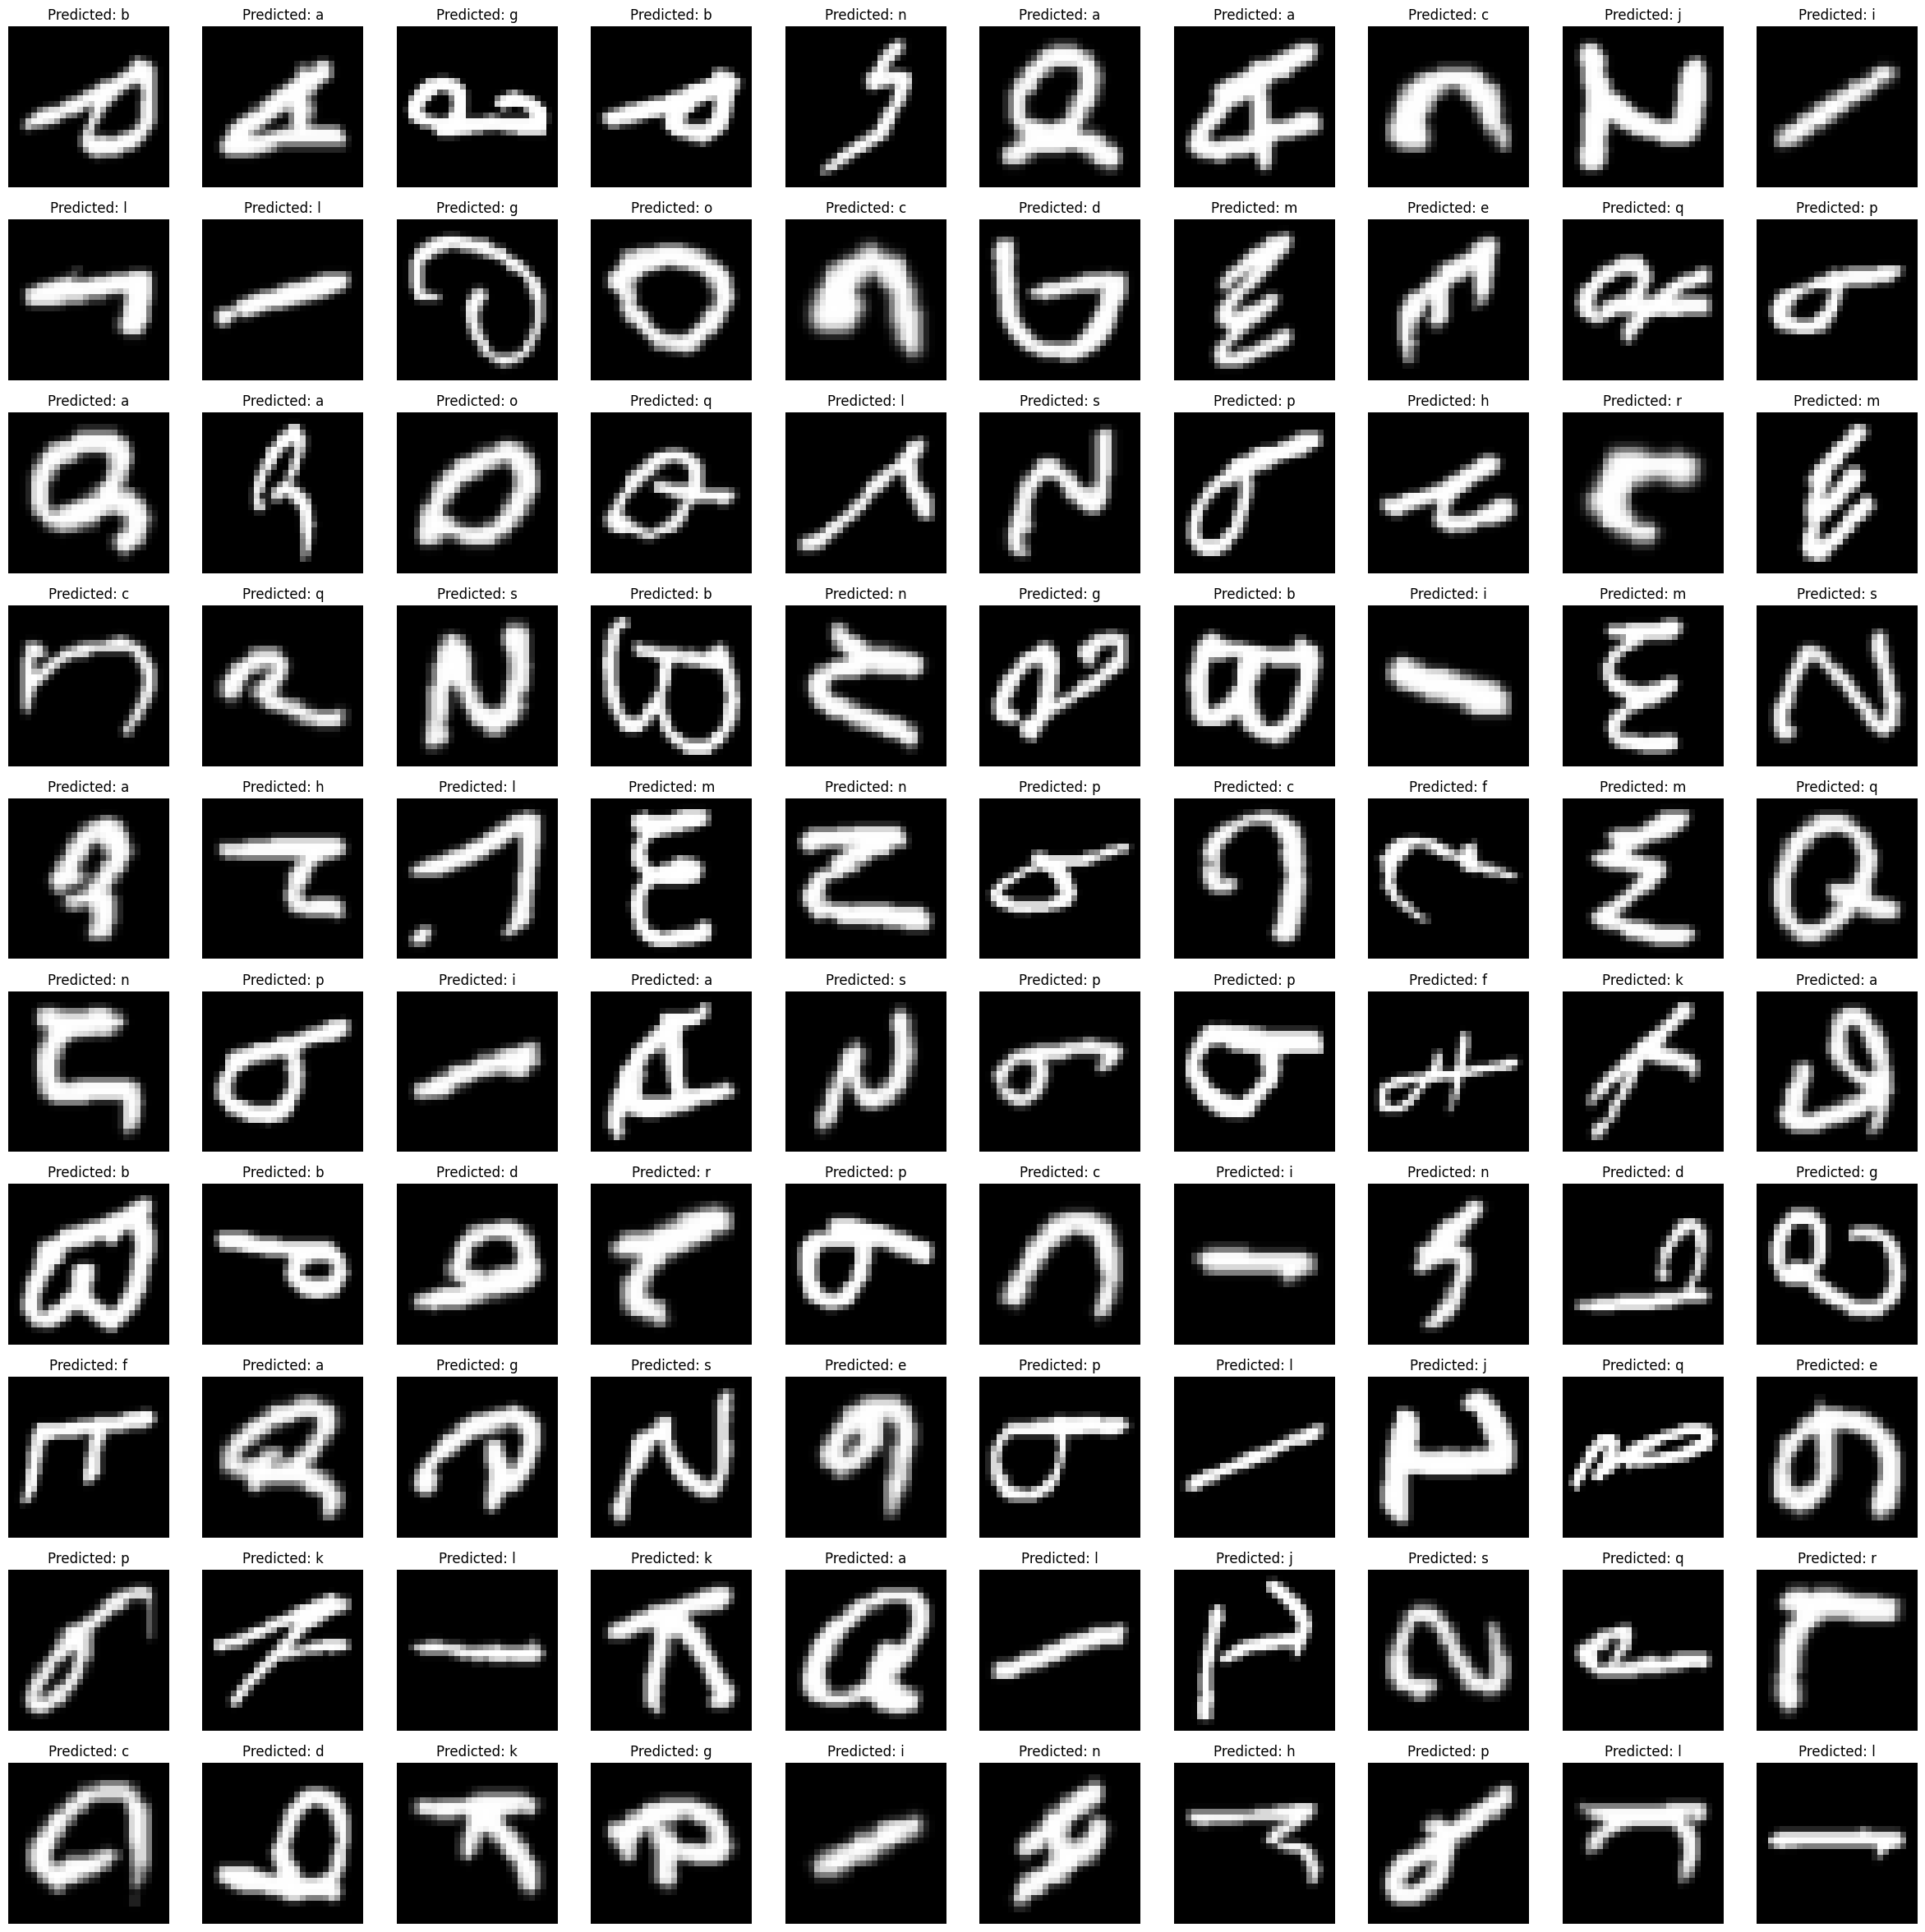

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

train = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
test = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
d = {}
for i in range(1, 27):
    d[i] = chr(96 + i)
y = train['23']
Y = np.array(y)
x = train.iloc[:,1:785]
Y = Y - 1

X = x.values.reshape(-1, 28, 28)
X = (X>=127).astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.15, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
HEIGHT, WIDTH = 28, 28

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding = 'same', activation='relu',input_shape=(HEIGHT, WIDTH,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))),
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=26, activation='softmax'))

model.summary()


model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=20, batch_size=128, 
          validation_data=(xval, yval), 
          callbacks=[early_stopping])

model.save('handwritten_text_recognition.h5')

test_loss, test_acc = model.evaluate(xtest, ytest)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')


test = test/255
testing = test.iloc[:, 1:].values.reshape(-1, 28, 28)

ypred = model.predict(testing)
ypred = np.argmax(ypred, axis=1)

random_indices = np.random.randint(0, len(test), 100)



fig, axs = plt.subplots(10, 10, figsize=(30, 30))
for i, a in enumerate(axs.flat):
    index = random_indices[i]
    a.imshow(test.iloc[index, 1:].values.reshape(28, 28), cmap='gray')
    a.axis('off')
    a.set_title(f"Predicted: {d[ypred[index]+1]}")
plt.show()

(-0.5, 939.5, 42.5, -0.5)

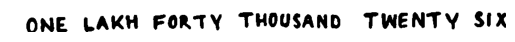

In [32]:
img = cv2.imread('/kaggle/input/cheque/test_cheque_1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
binary_image = initial_filter(img)
segmented = binary_image[250: 293, 260: 1200]
plt.imshow(segmented, cmap='gray')
plt.axis('off')

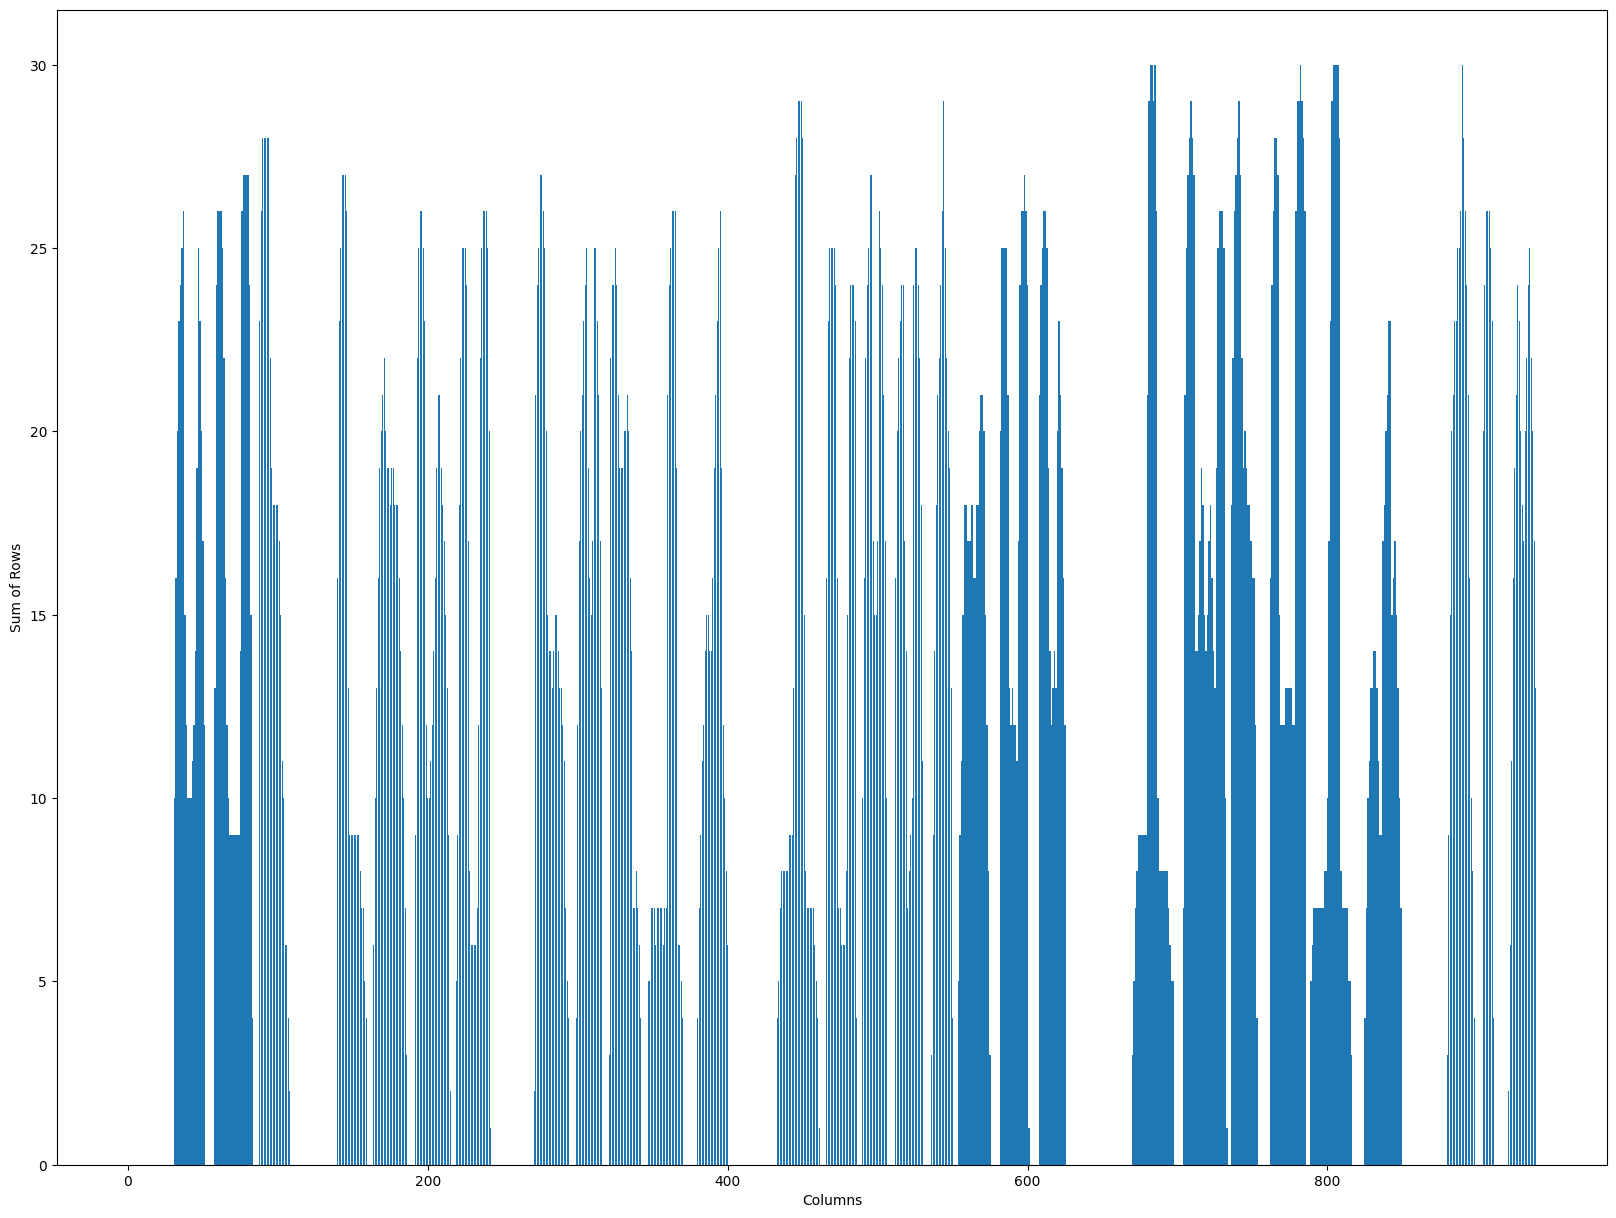

In [33]:
column_sums = calculate_col_sums(segmented)

In [37]:
start_coords, end_coords = calculate_coords(column_sums)

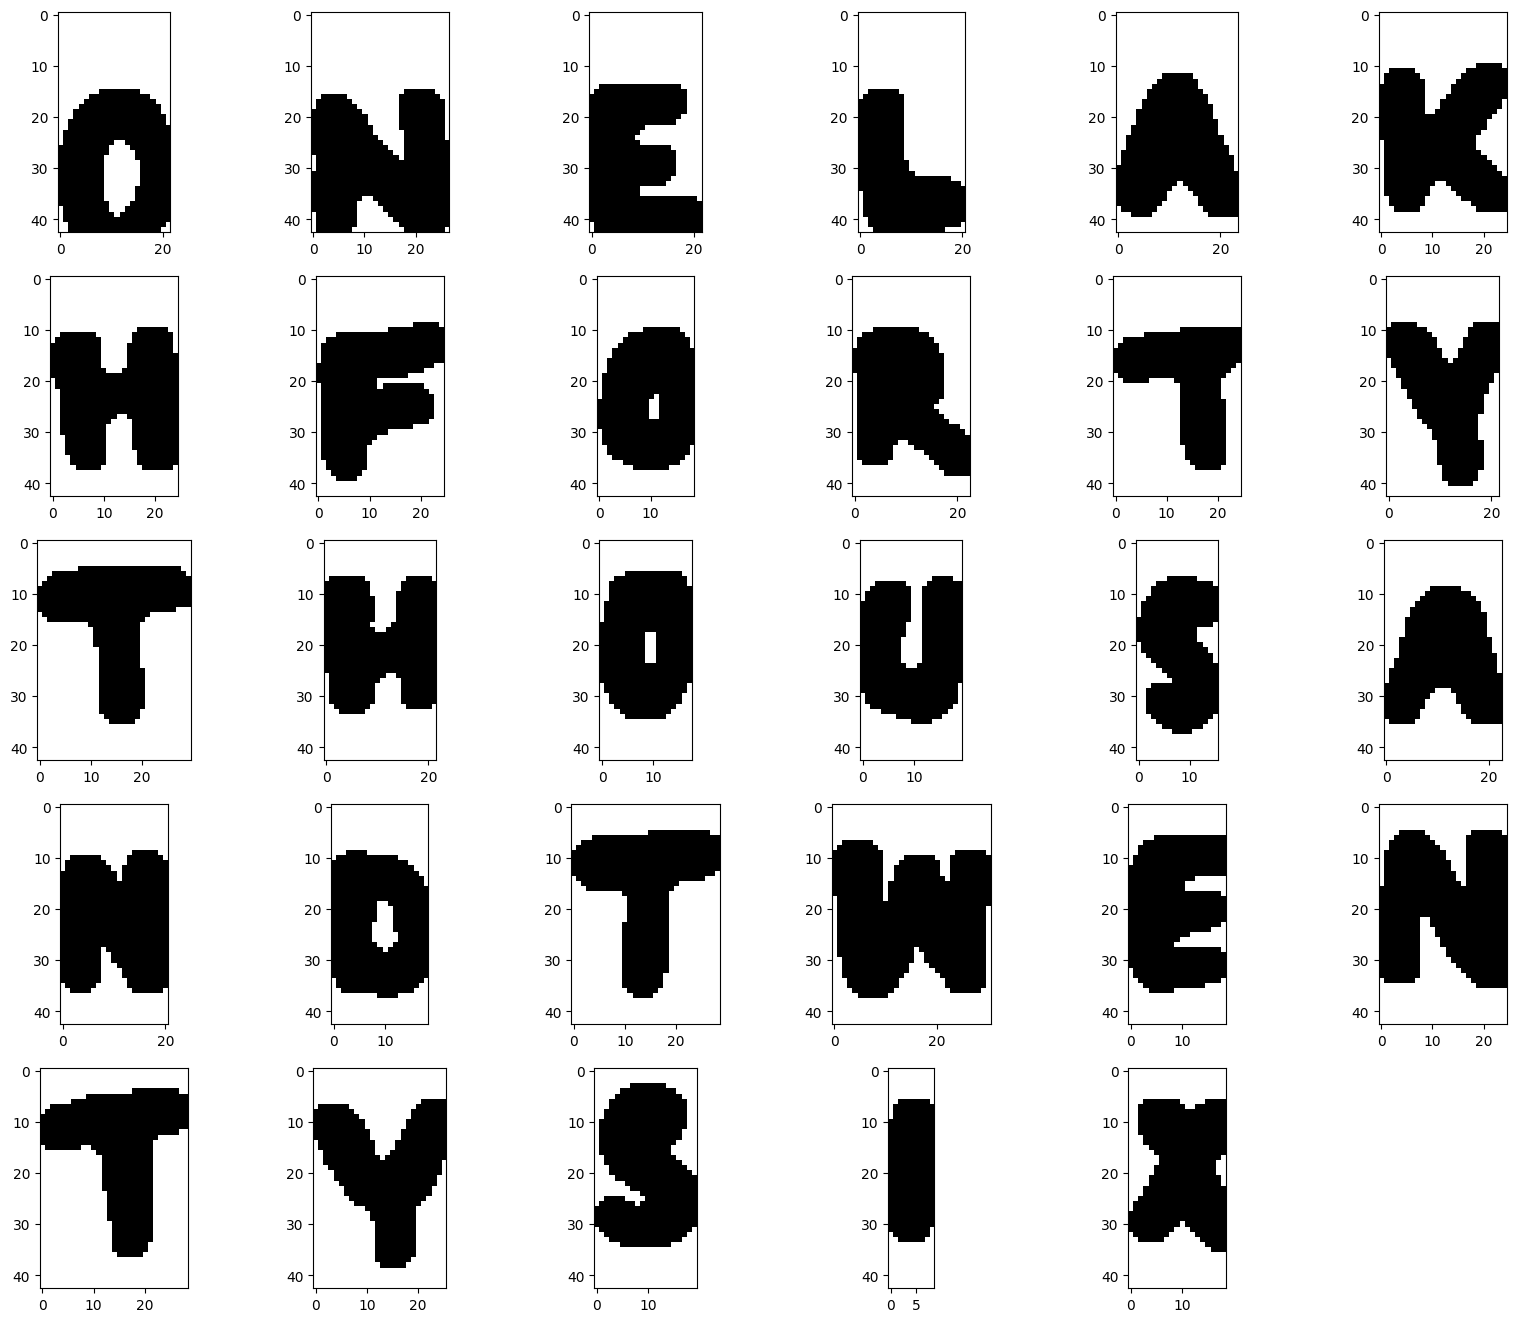

In [38]:
images = filtering(start_coords, end_coords, segmented)

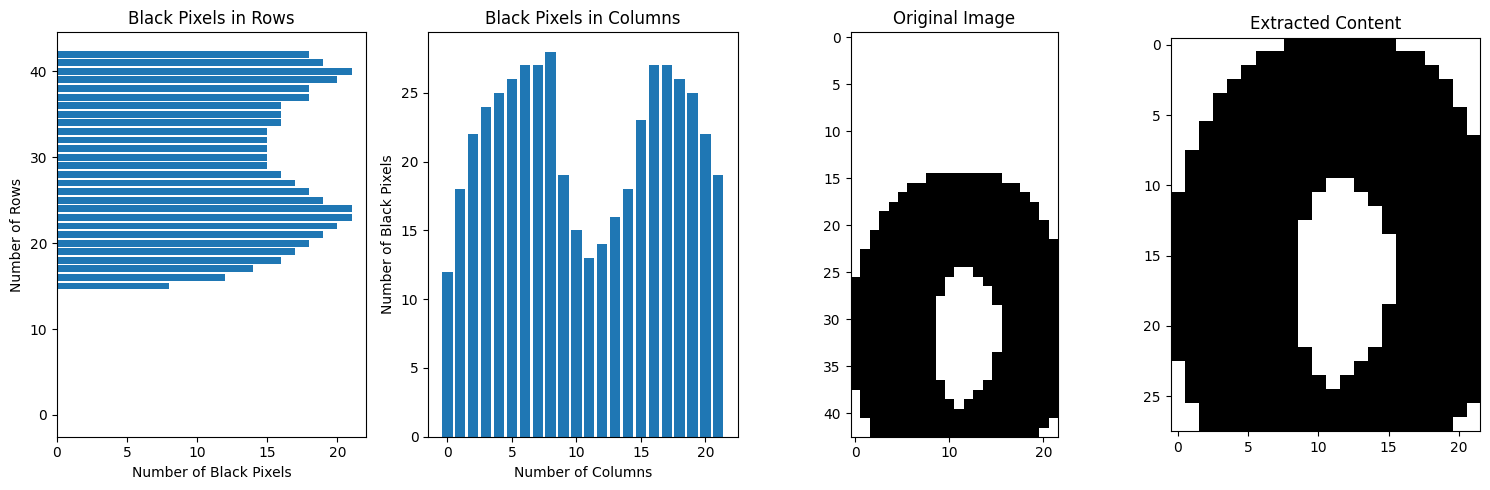

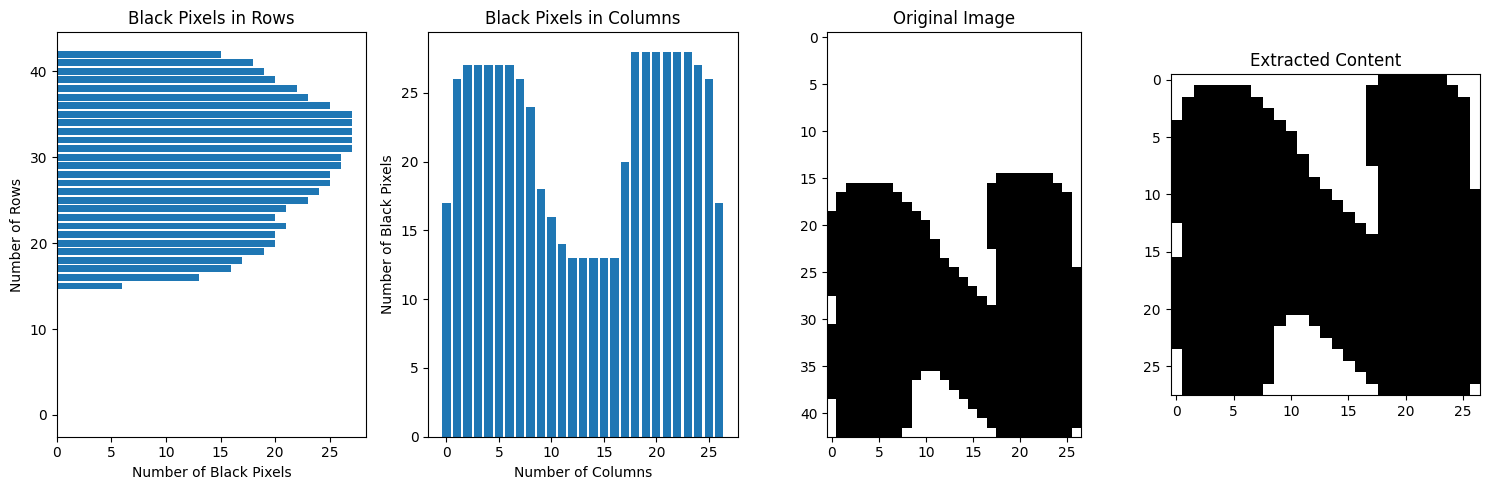

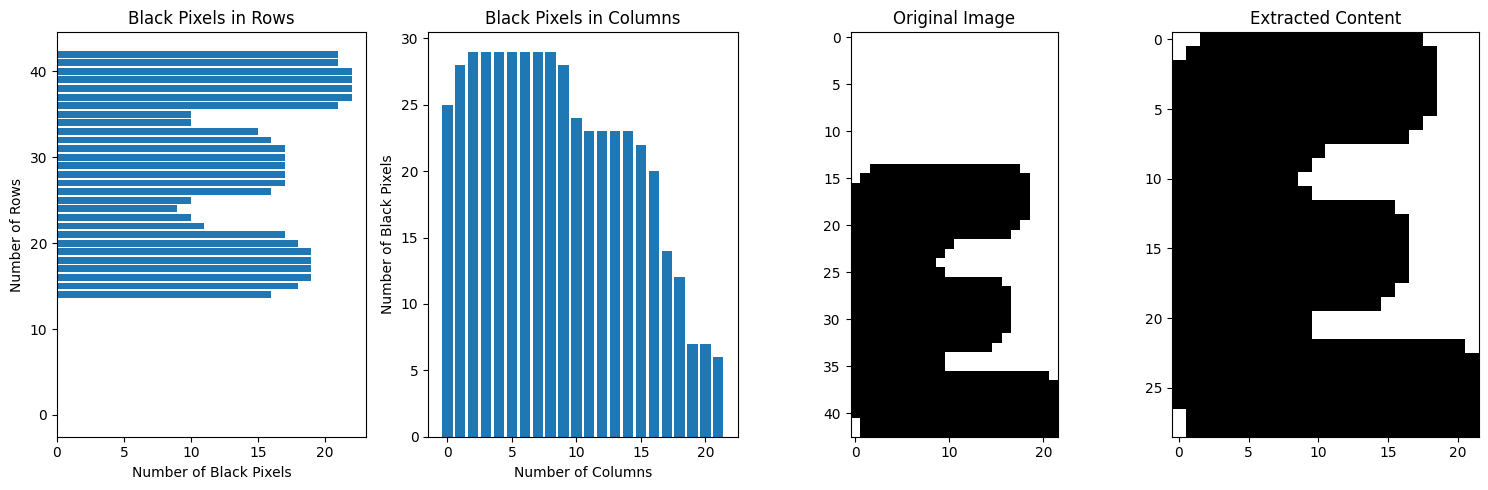

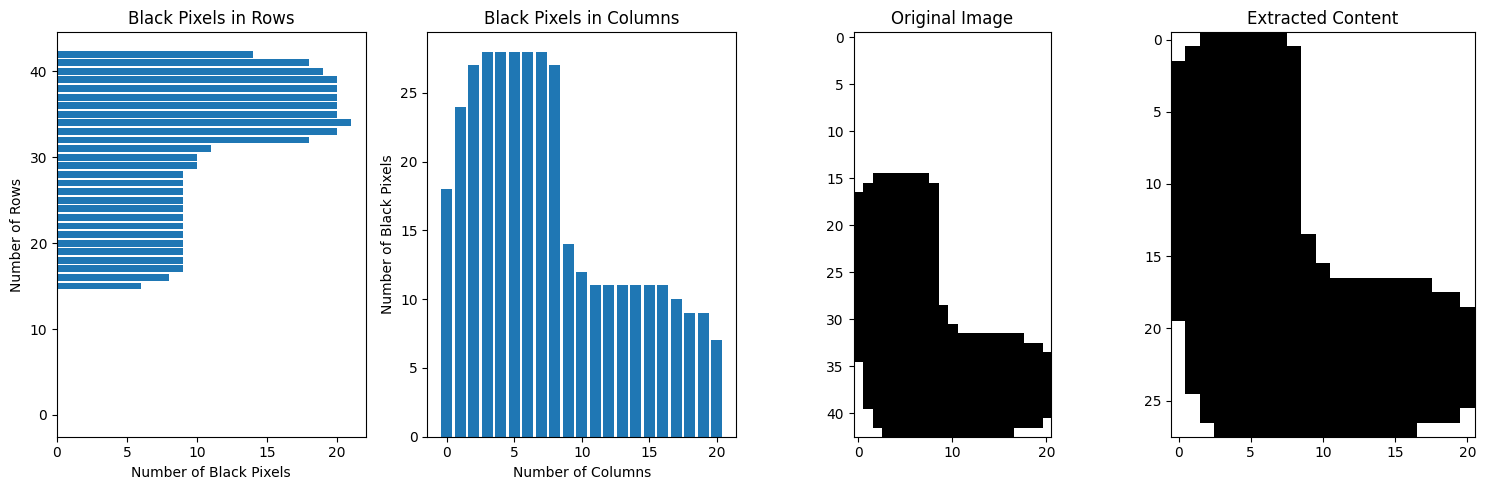

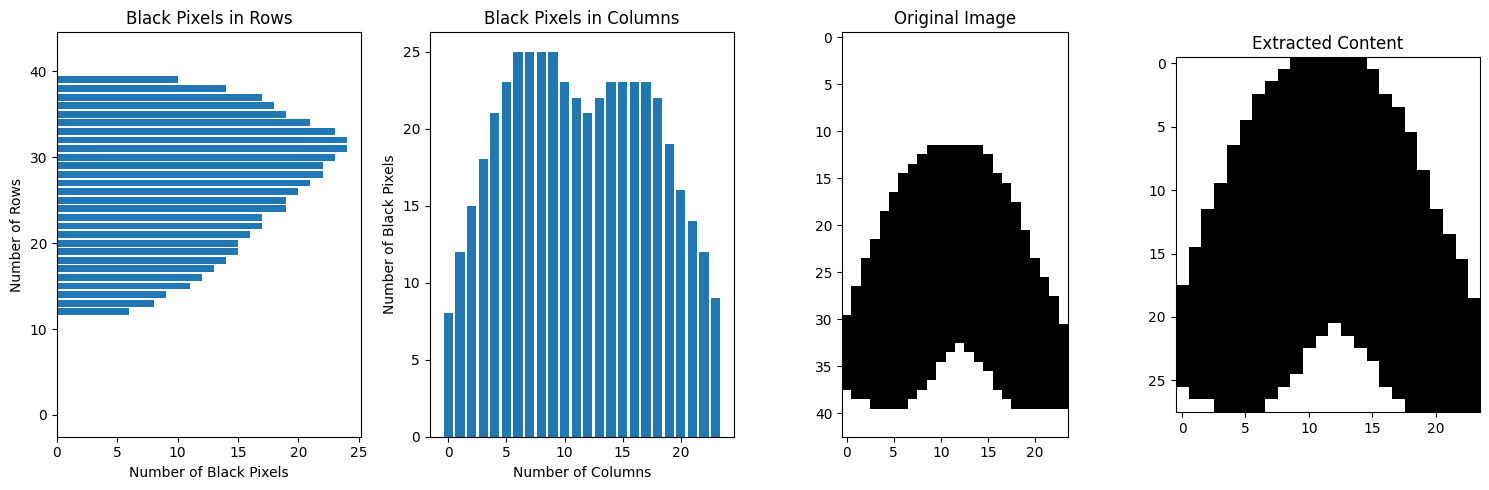

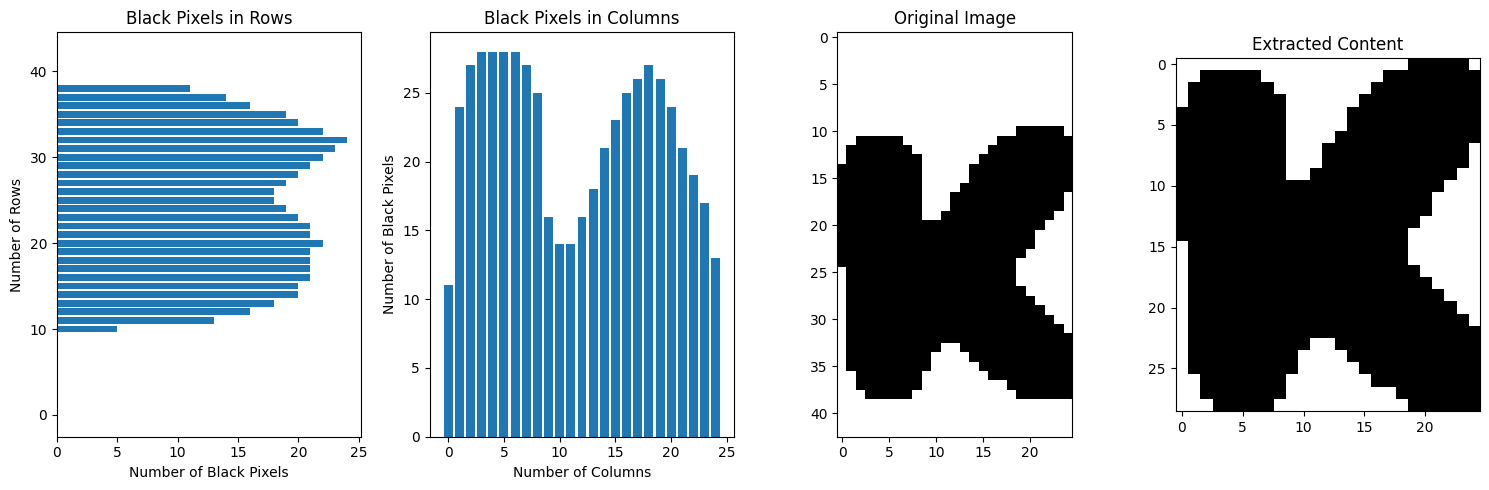

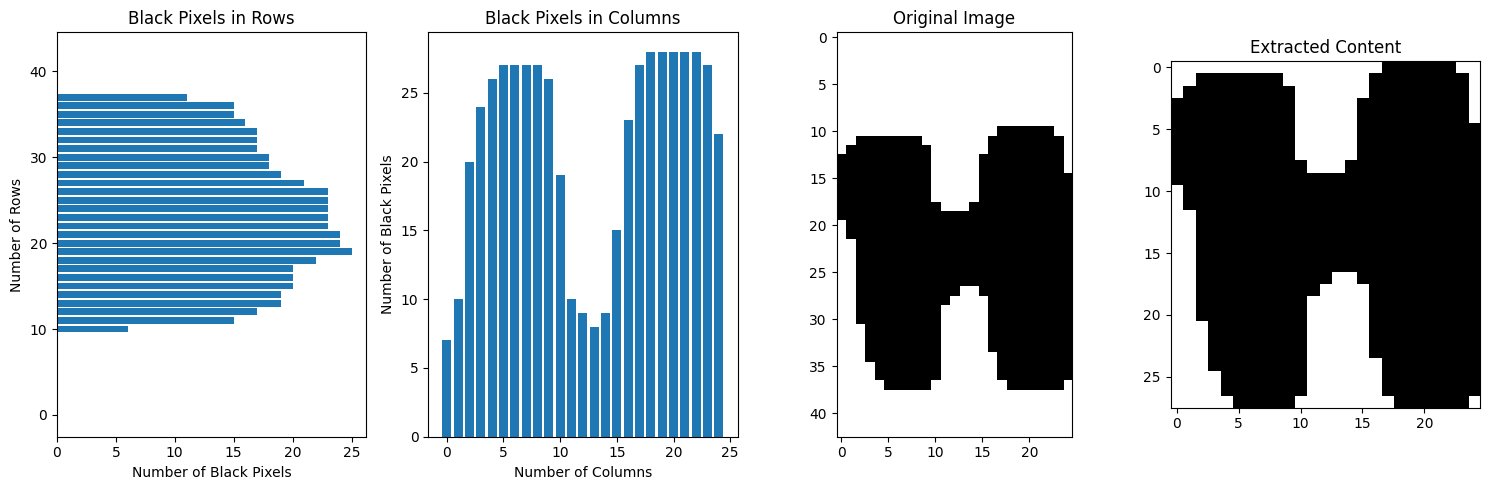

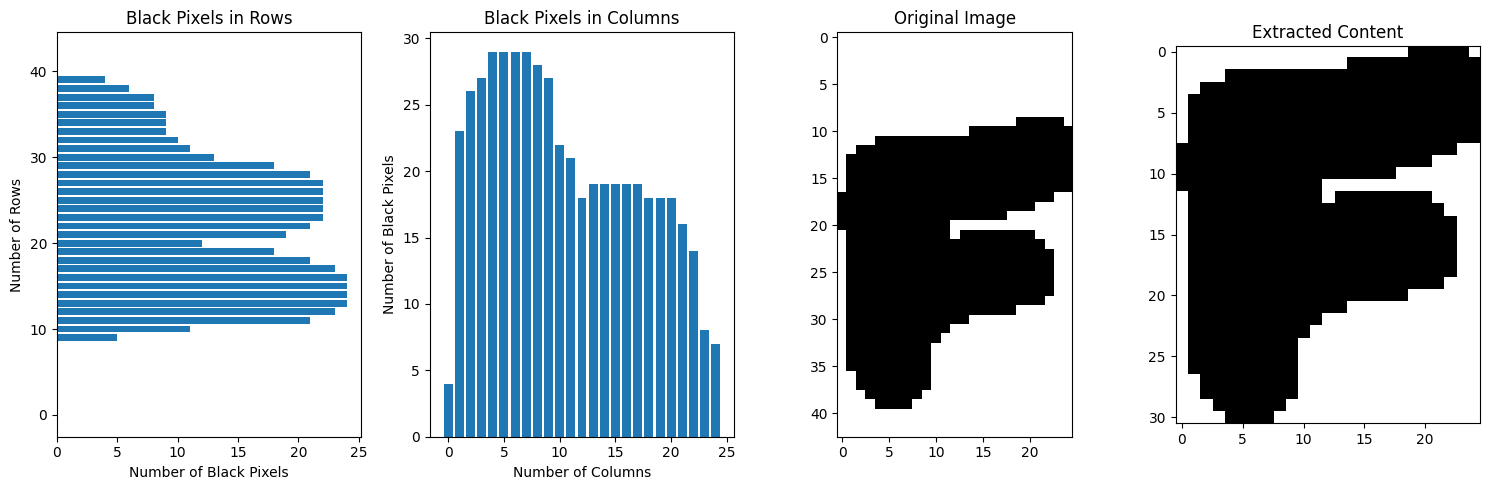

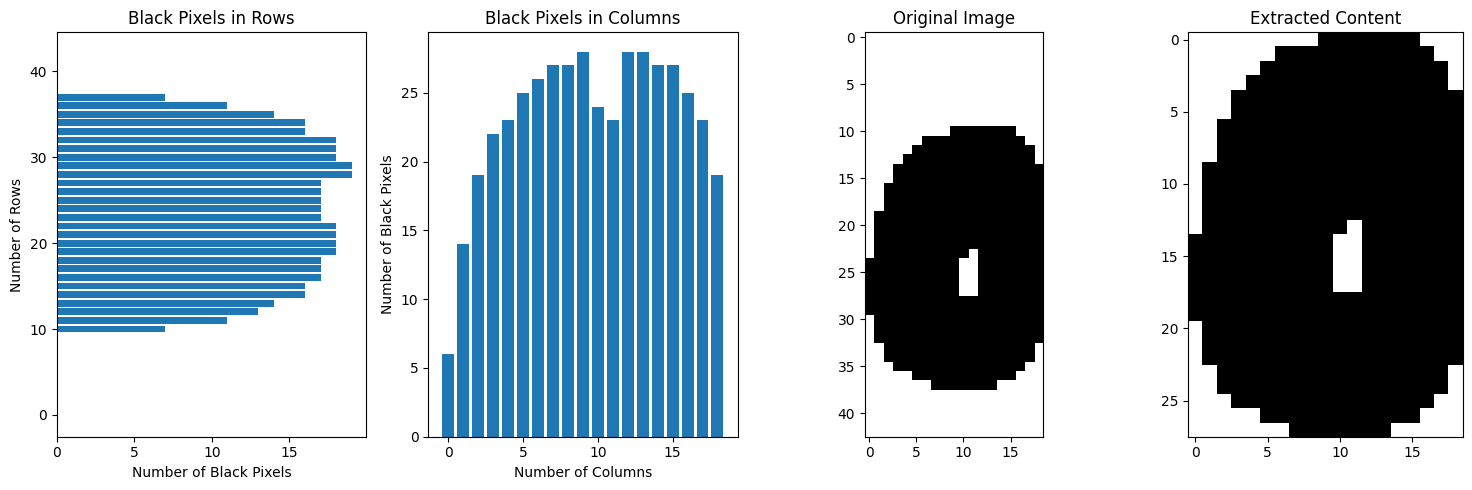

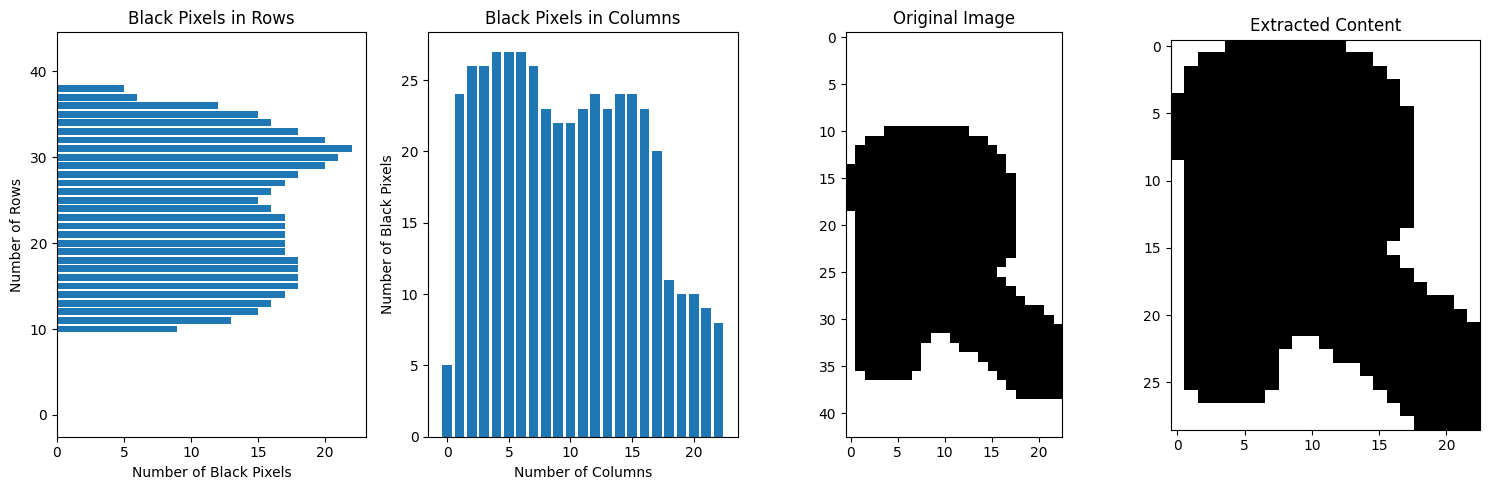

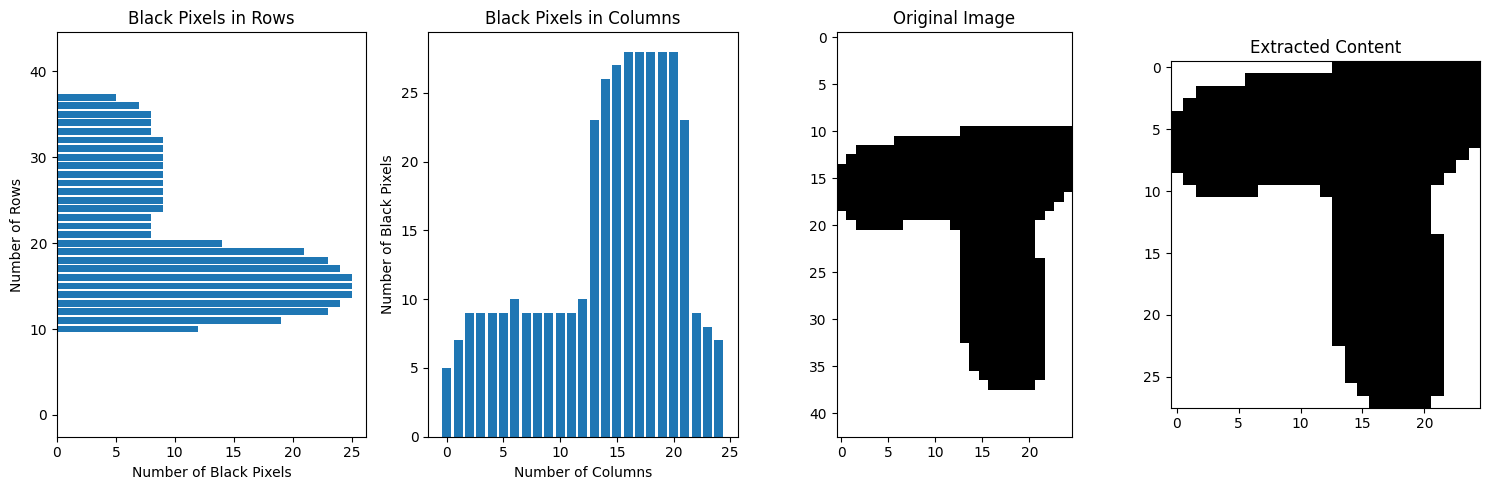

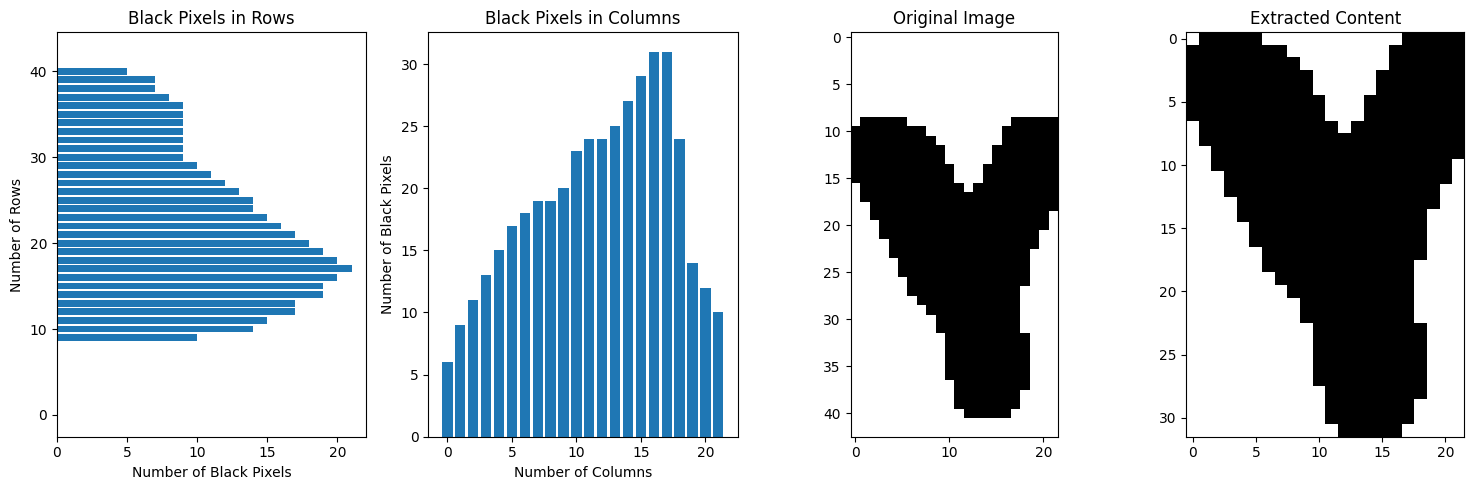

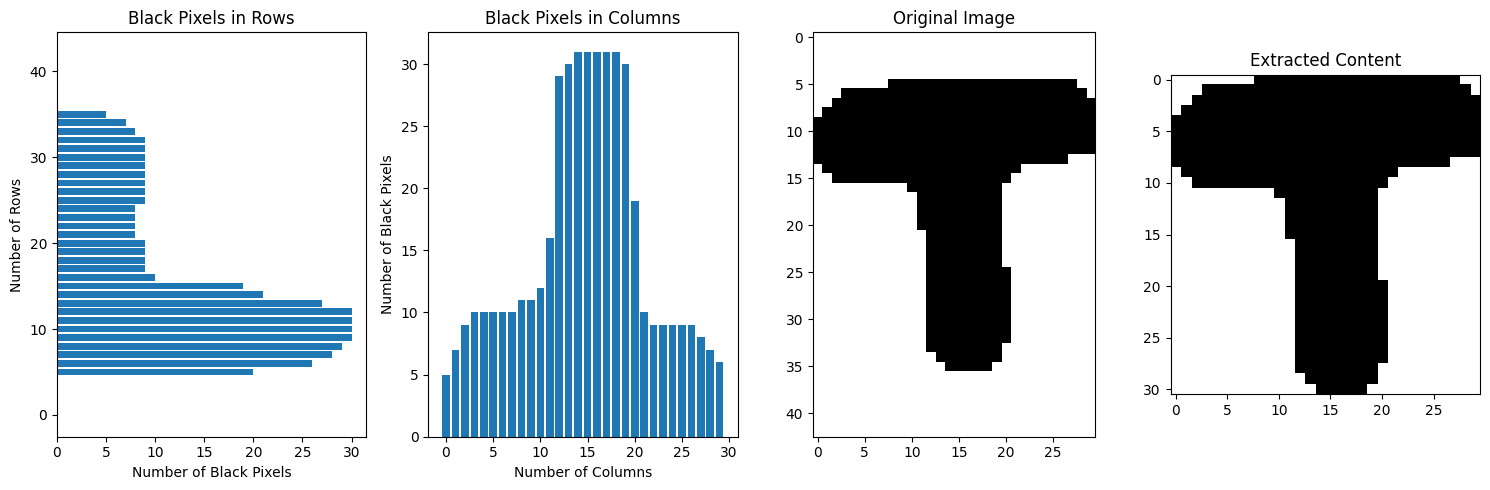

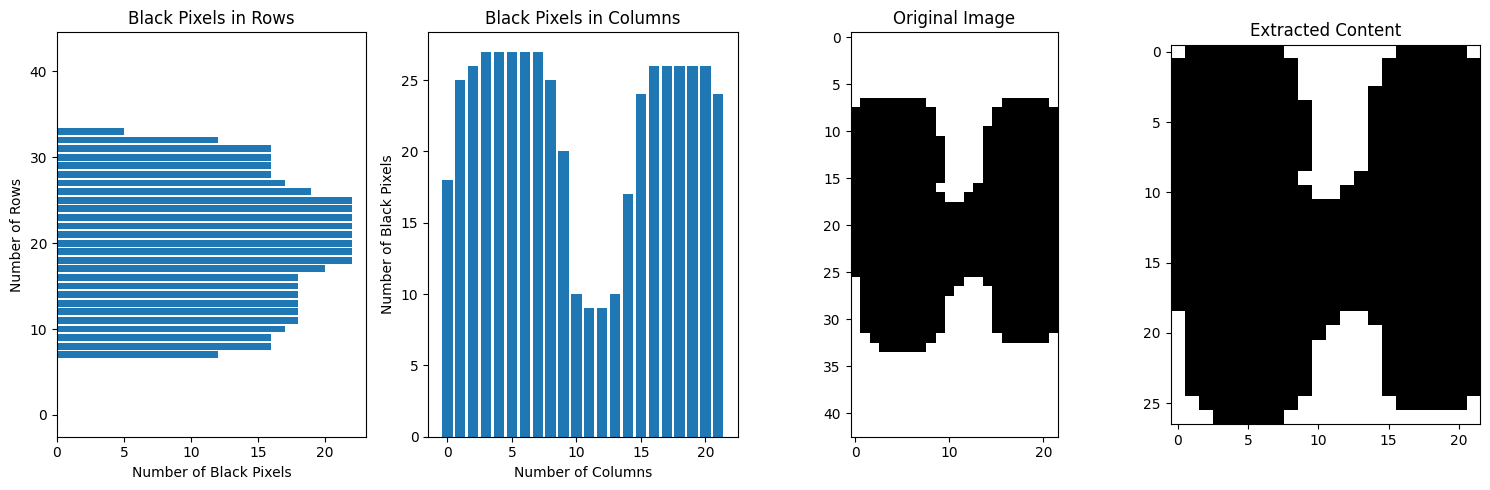

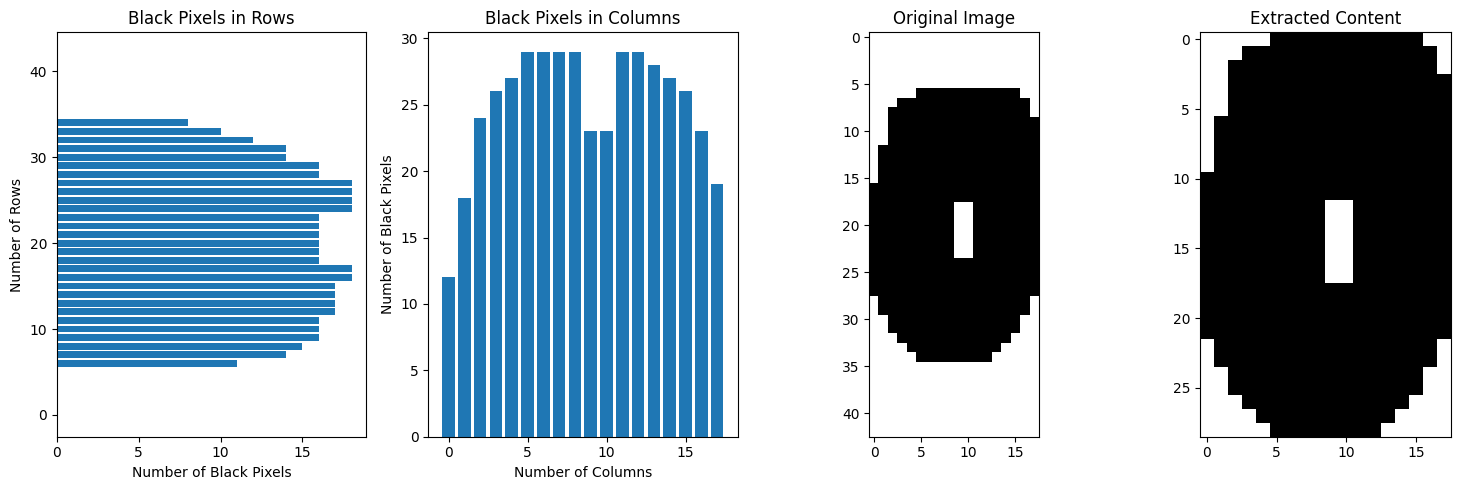

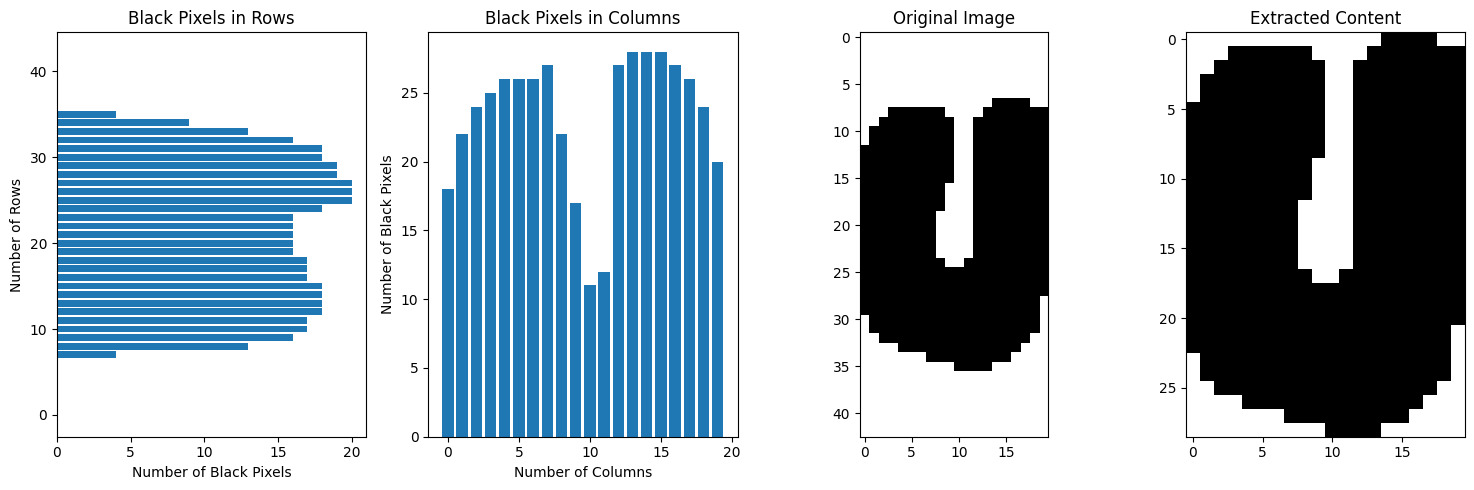

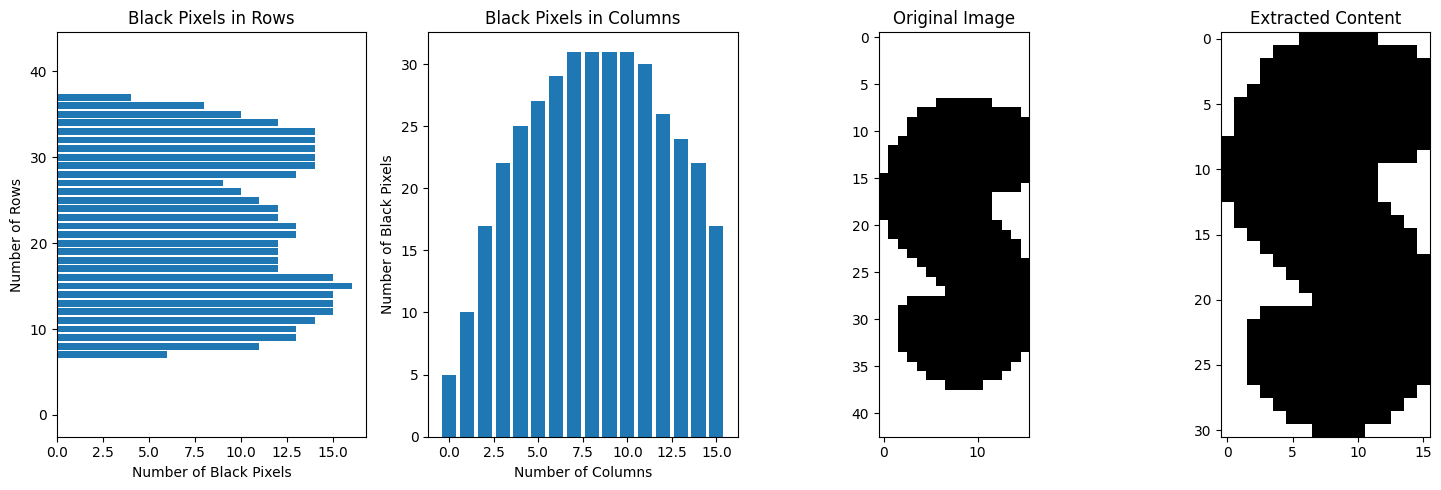

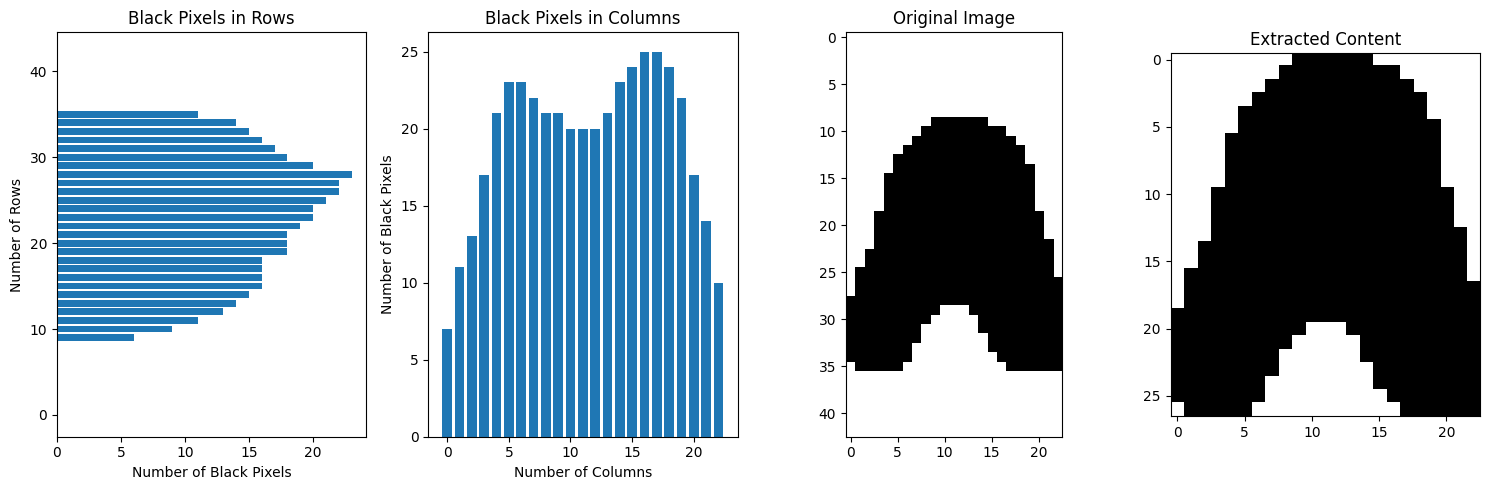

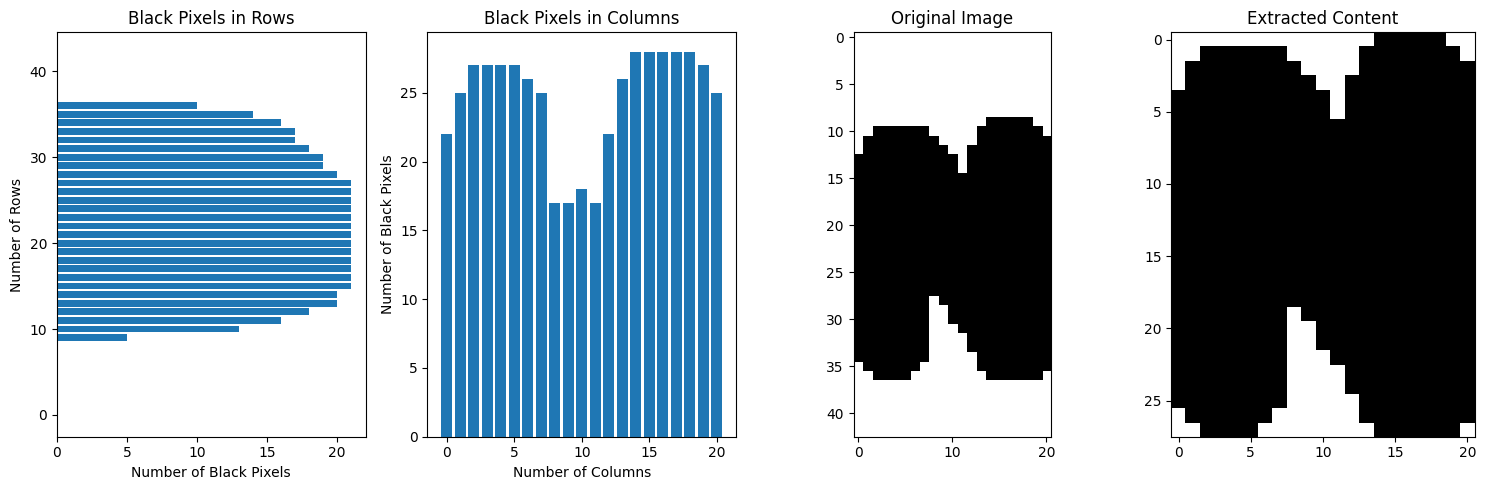

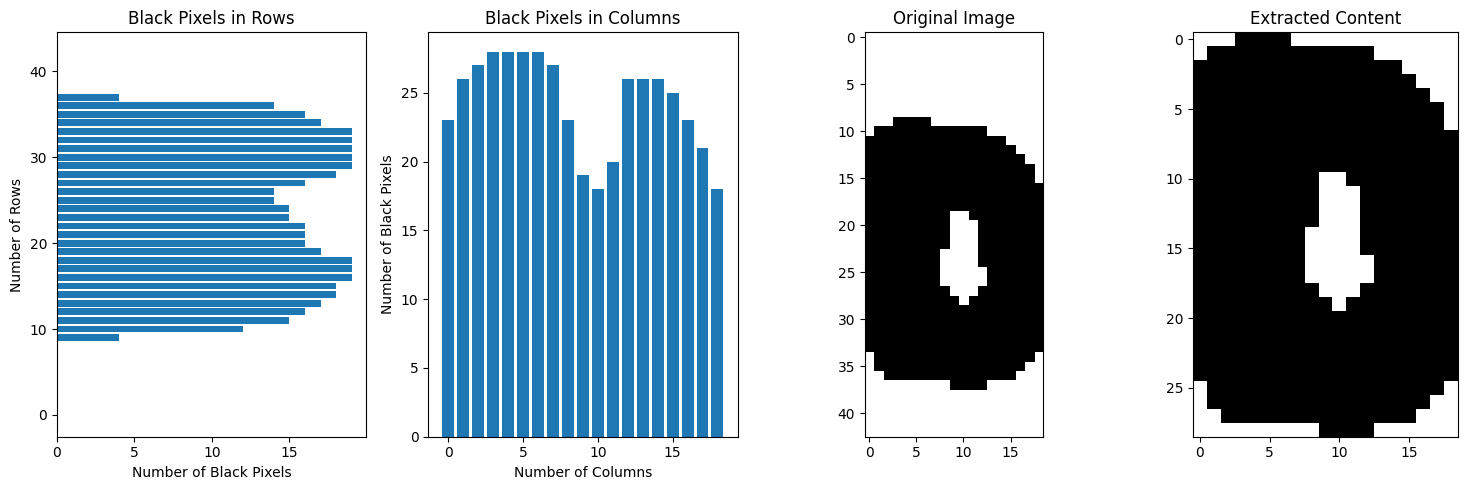

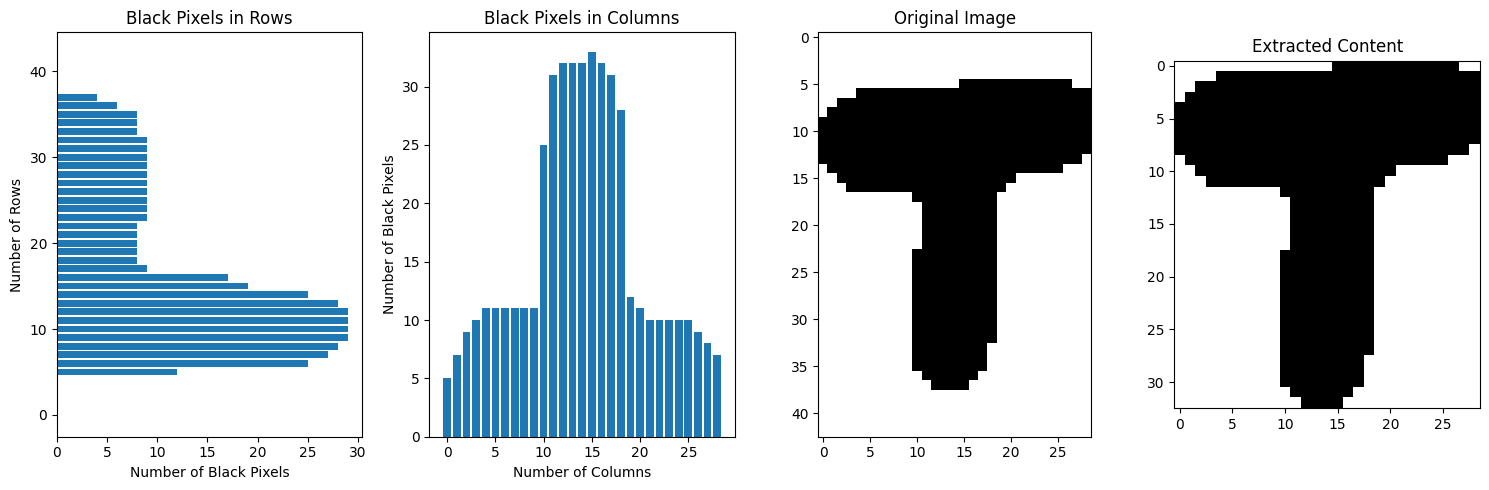

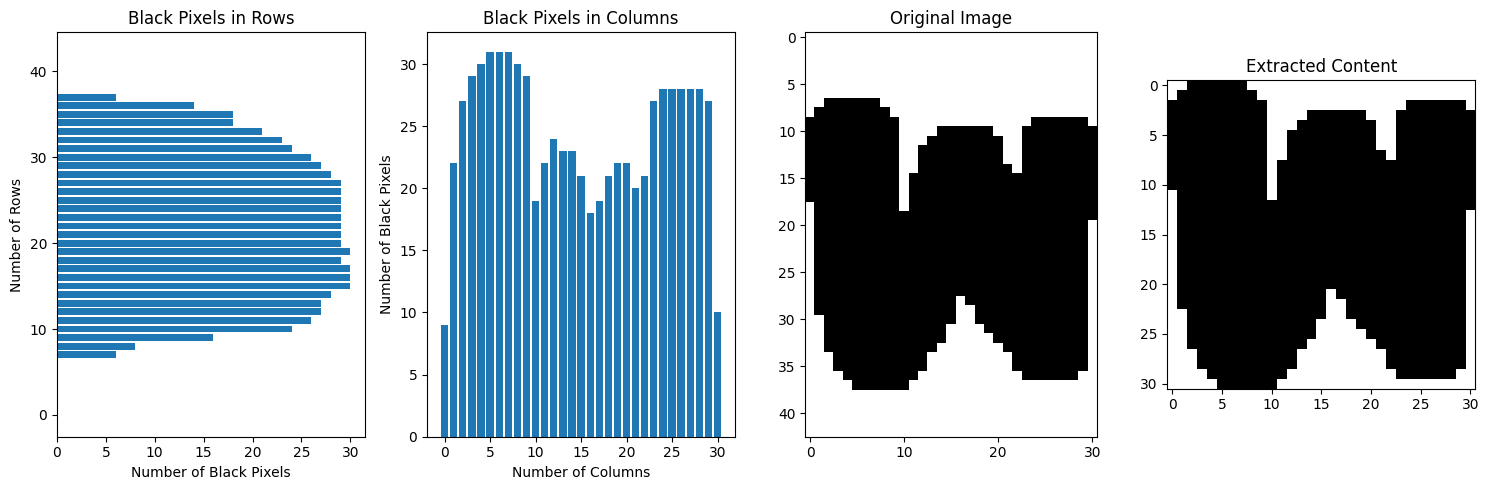

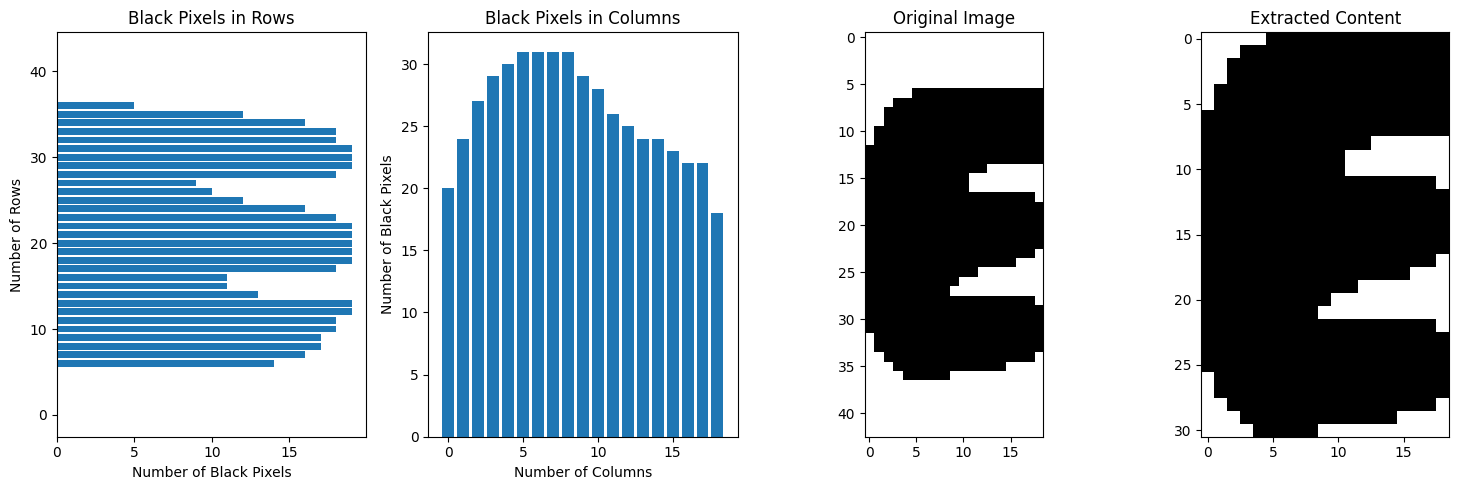

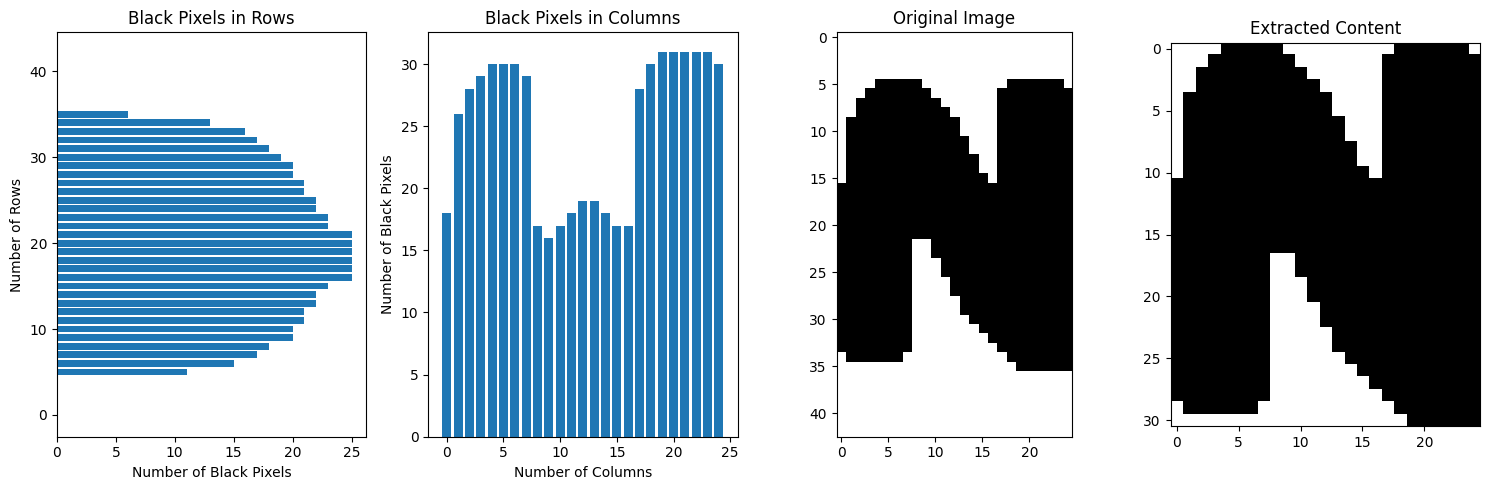

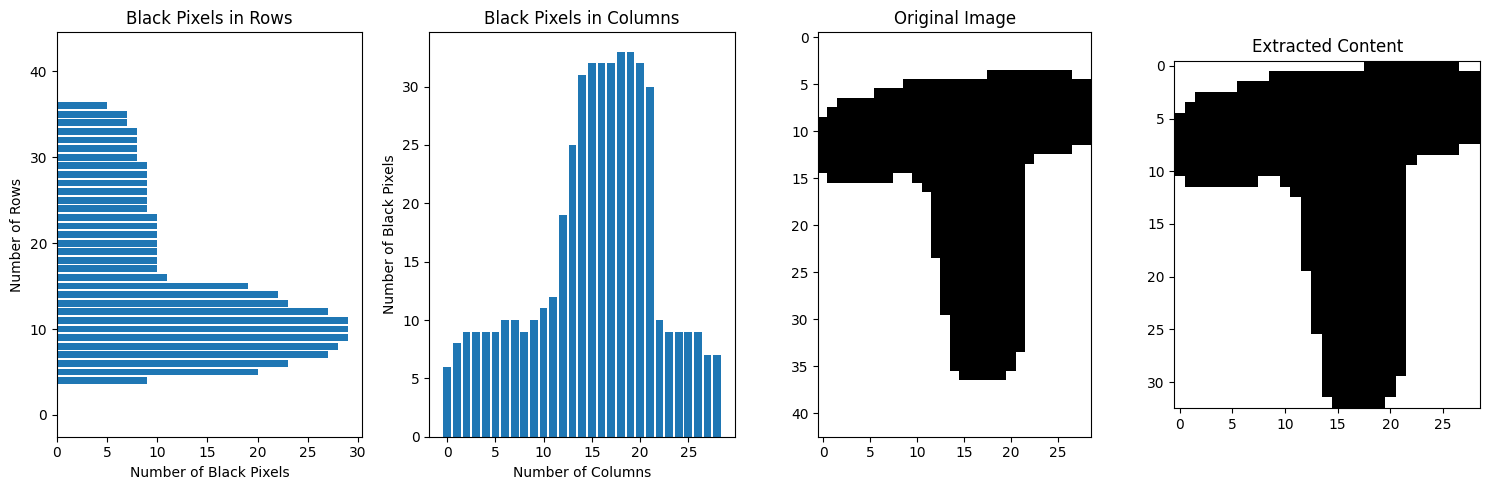

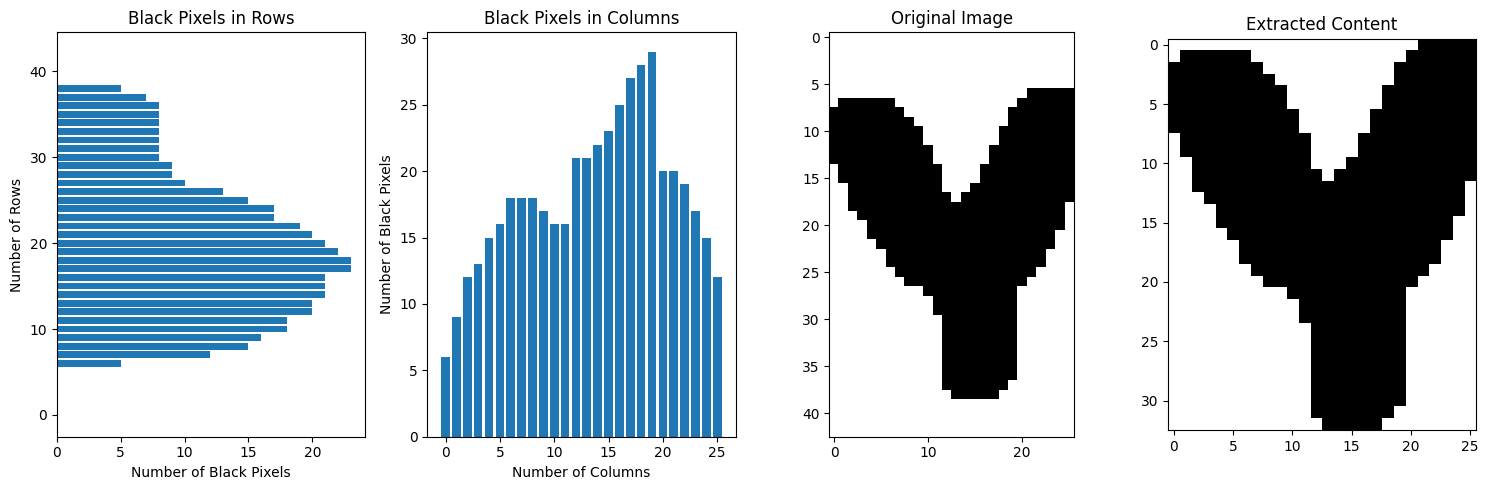

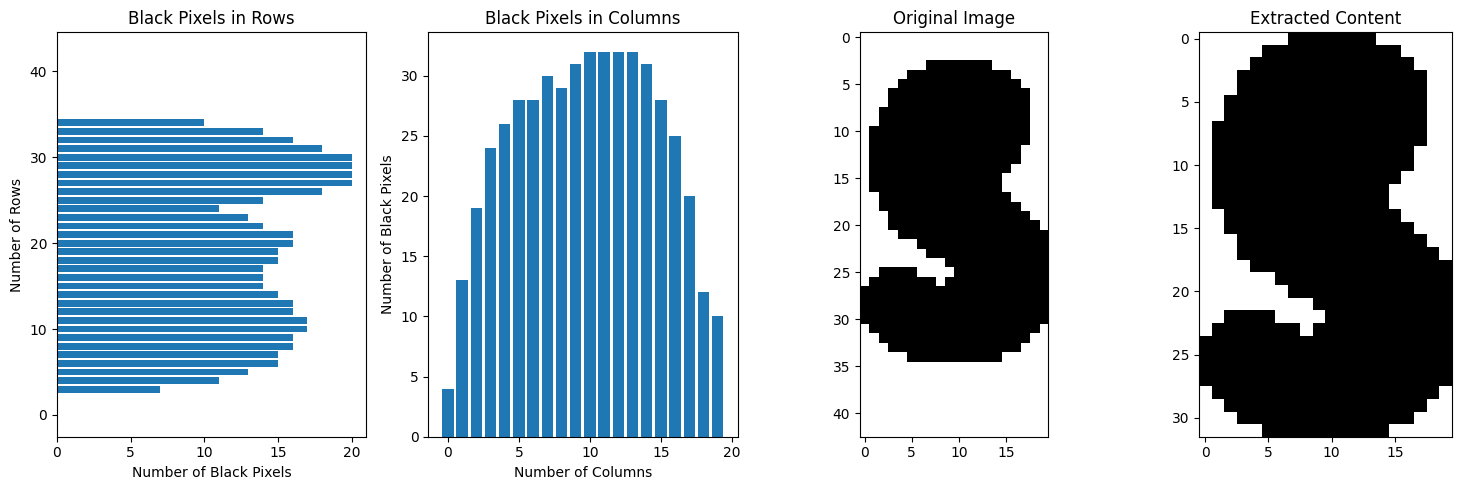

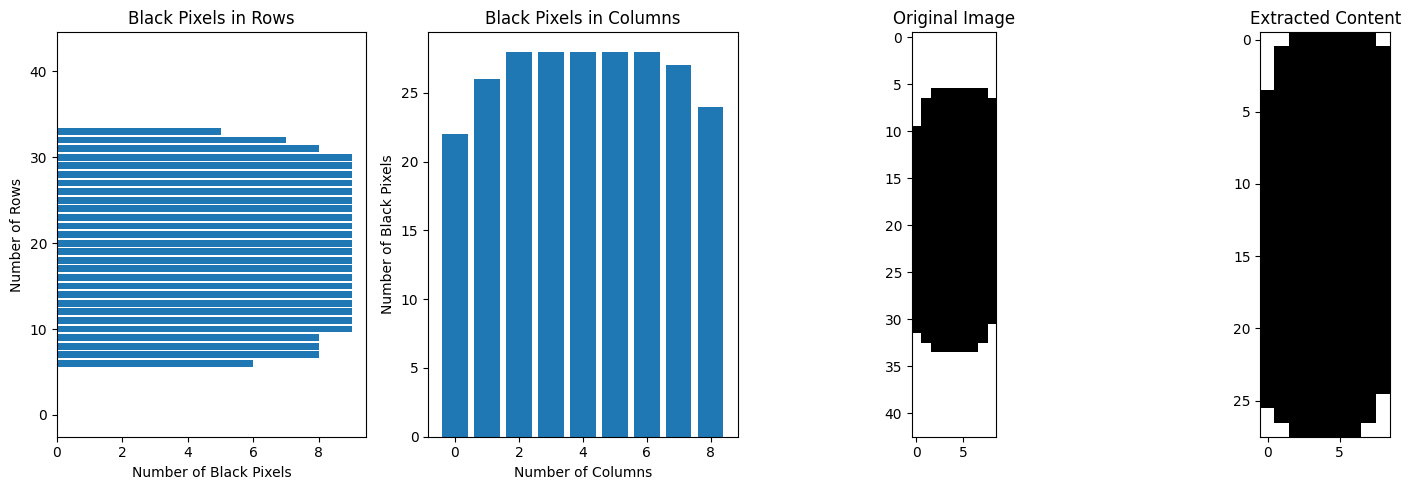

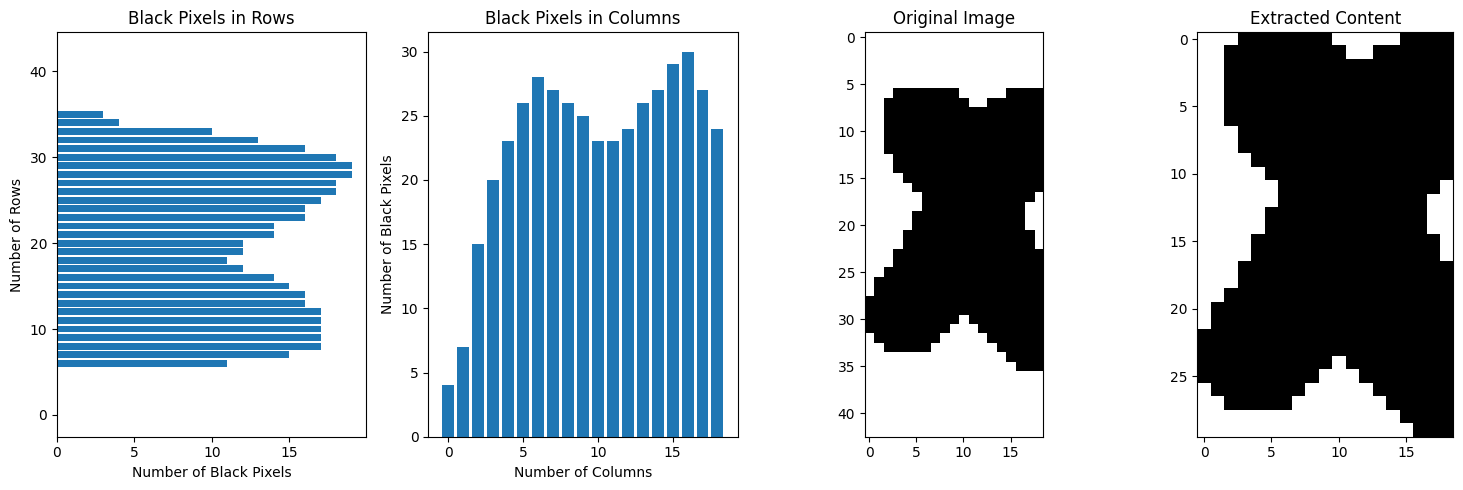

In [39]:
images = extract_content(images)

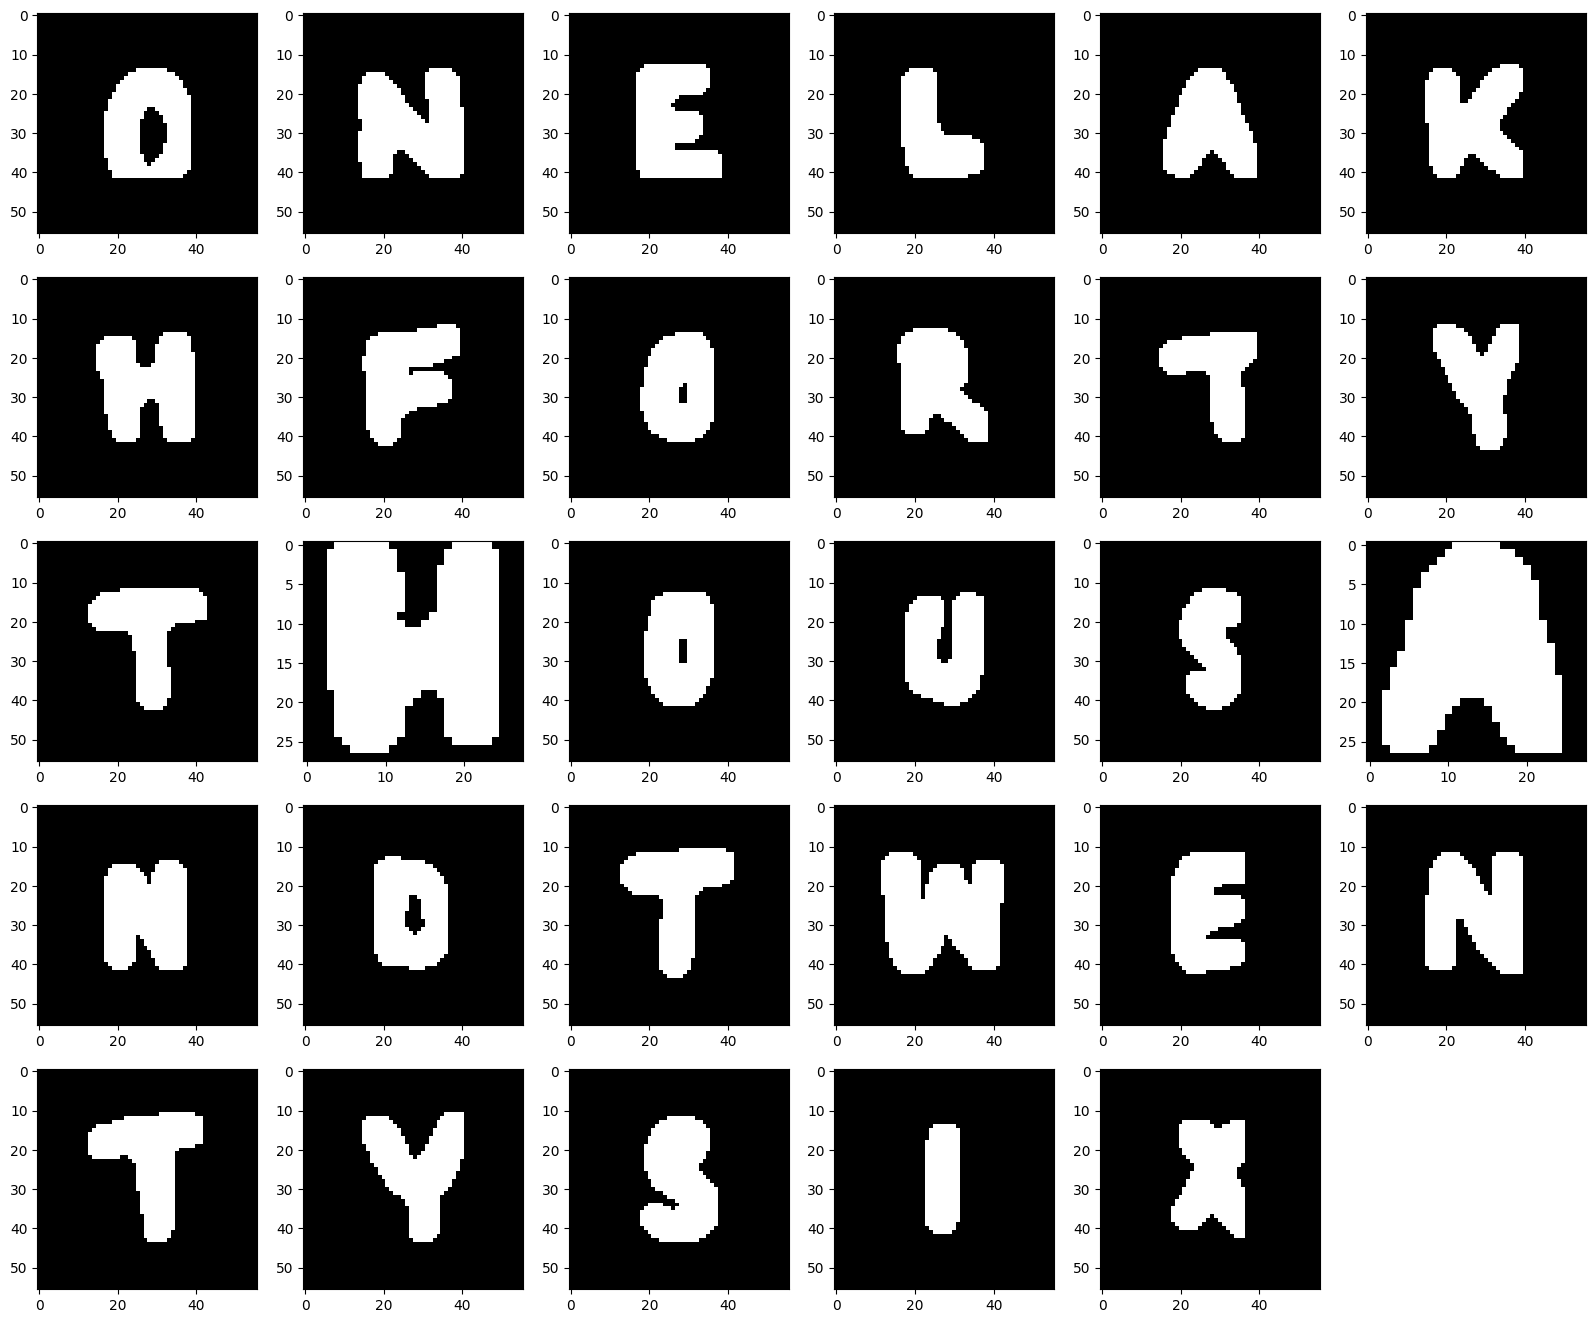

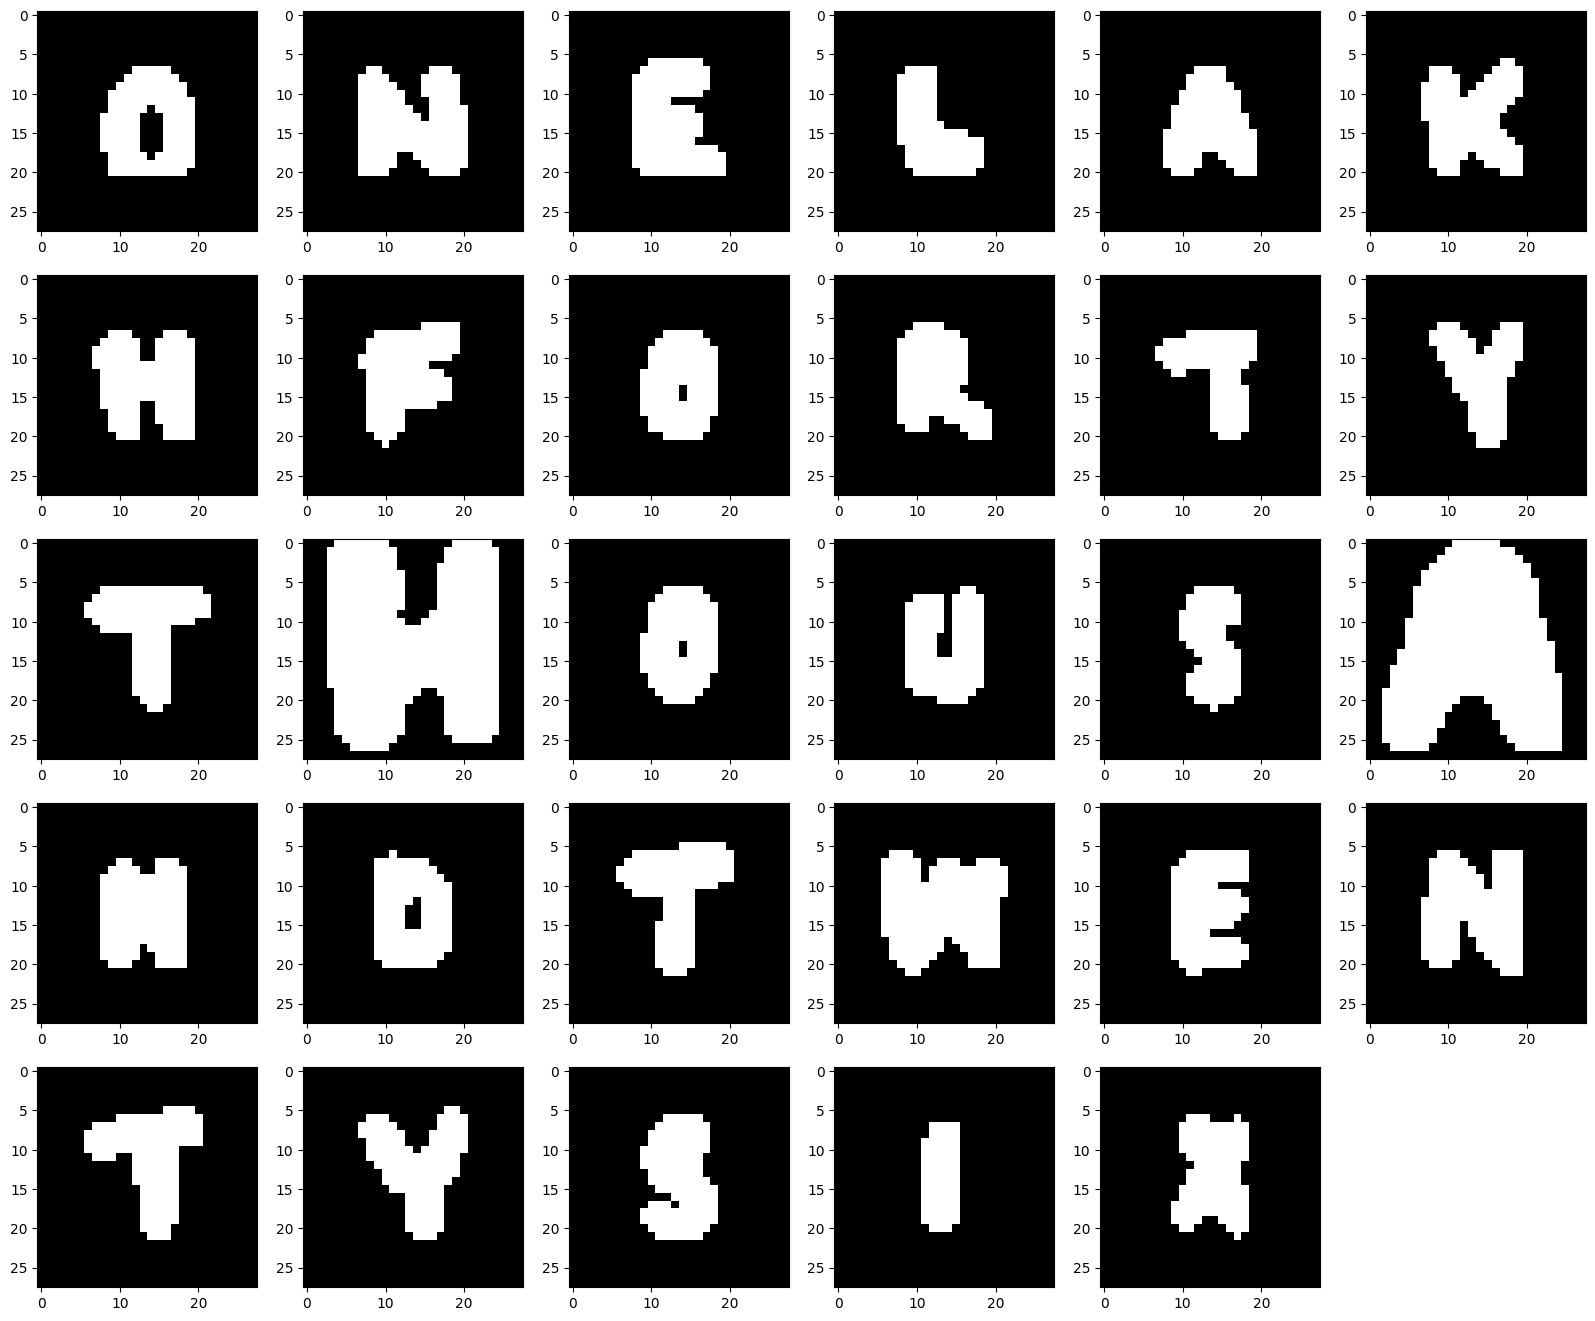

In [40]:
resized_images = resized(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

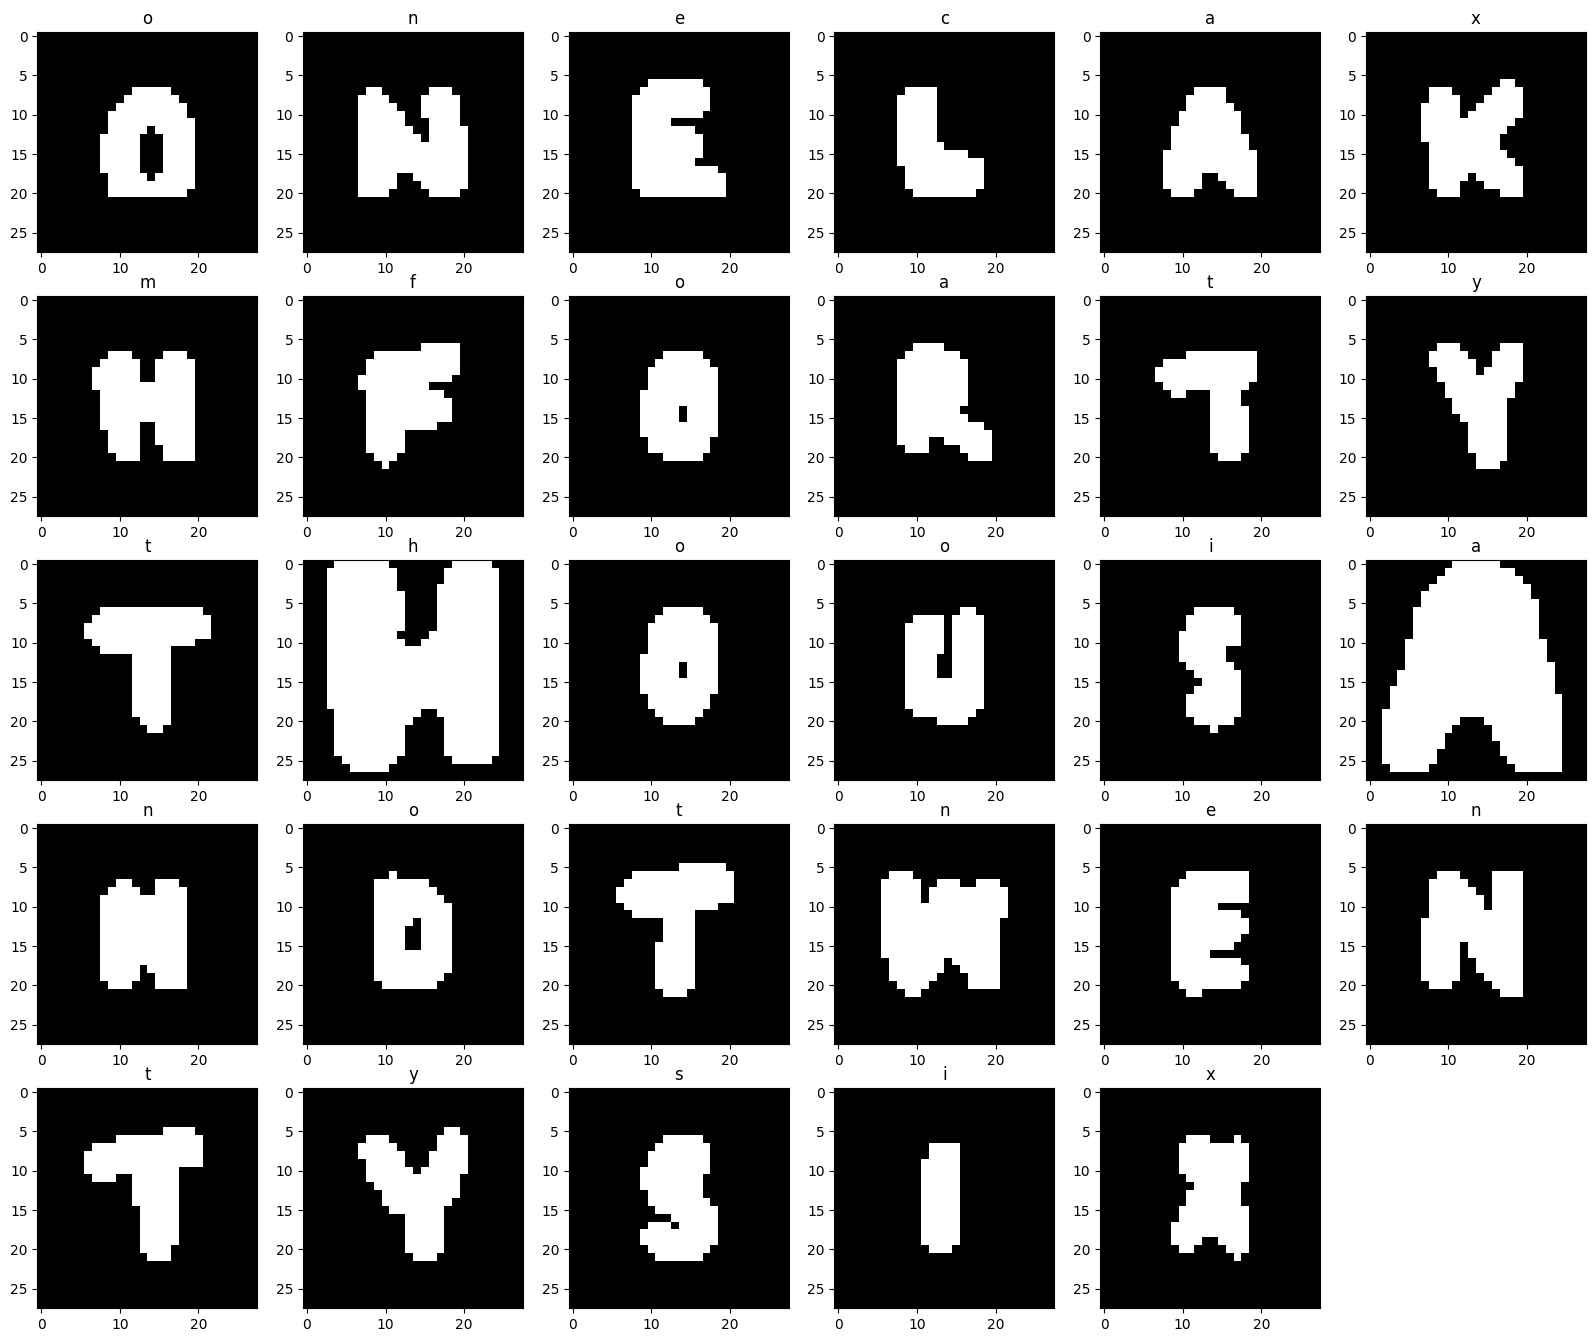

In [41]:
extracted = predict_letters(resized_images)

In [42]:
actual_name = find_spaces(start_coords, end_coords, extracted)
print("Detected text: ", actual_name)

Detected text:  one caxm foaty thooiano tnenty six


In [45]:
d = {}

for i in range(26):
    d[i] = chr(65+i)

total_digits = {3: ['one', 'two', 'six', 'ten'], 
                4: ['four', 'five', 'nine', 'lakh'], 
                5: ['three', 'seven', 'eight', 'forty', 'fifty', 'sixty', 'lakhs', 'crore'], 
                6: ['eleven', 'twelve', 'twenty', 'thirty', 'eighty', 'ninety'], 
                7: ['fifteen', 'sixteen', 'seventy', 'hundred'], 
                8: ['thirteen', 'fourteen', 'eighteen', 'nineteen', 'thousand'], 
                9: ['seventeen']}

def match_string(string):
    string = list(string.split())
    d = {}
    list_to_check = []
    for i in range(len(string)):
        d[i] = []
    for i in range(len(string)):
        if 3<=len(string[i])<=9:
            list_to_check = total_digits[len(string[i])]
        x = string[i]
        values, percent = [], []
        m = 0
        for j in range(len(list_to_check)):
            if sum(np.array(list(list_to_check[j])) == np.array(list(string[i])))>=m:
                x = list_to_check[j]
                values.append(x)
                m = sum(np.array(list(list_to_check[j])) == np.array(list(string[i])))
                percent.append(m)
        string[i] = x
        for k in range(len(values)):
            if percent[k] == max(percent):
                d[i].append(values[k])
    return d


def generate_combinations(data, index=0, current_combination=[]):
    if index == len(data):
        yield ' '.join(current_combination)
    else:
        for word in data[index]:
            for combination in generate_combinations(data, index + 1, current_combination + [word]):
                yield combination

def str_to_num(string):
    values = {'crore': 10**7, 'lakh': 10**5, 'lakhs': 10**5, 'thousand': 10**3, 'hundred': 100}
    num = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9,
             'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15, 
              'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 
             'twenty': 20, 'thirty': 30, 'forty': 40, 'fifty': 50, 'sixty': 60, 'seventy': 70, 'eighty': 80, 'ninety': 90}
    
    number = {'crore': 0, 'lakhs': 0, 'lakh': 0, 'thousand': 0, 'hundred': 0, 'unit': 0}
    
    m = 0
    
    string = list(string.split())
    
    for i in range(len(string)):
        if string[i] in ['crore', 'lakhs', 'lakh', 'thousand', 'hundred'] :
            number[string[i]] = m
            m = 0
        elif string[i] in num:
            m += num[string[i]]
    number['unit'] = m
    
    n = 0
    for x in number:
        if x == 'unit':
            break
        n += number[x] * values[x]
    n += number['unit']
    return n

In [46]:
data = match_string(actual_name)
a = []
for combination in generate_combinations(data):
    a.append(str_to_num(combination))
print('Possible outcome', *a)

Possible outcome 140026
